In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18aczbnhl,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18adairvu,No_TNS,None,-99.0,None
ZTF20aaiwhct,No_TNS,None,-99.0,None
ZTF20aberawv,No_TNS,None,-99.0,None


In [3]:
ann_dist_all_df = pd.read_csv('ann_dist_all_df_noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,WeightedMean-9ANNs
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,0,2414,2989,1850,975,644,3001,2268,2969,2298,...,66.066551,68.658409,68.756905,68.802032,69.448929,70.149521,71.245369,71.404274,68.726116,66.379790
ZTF17aadqidc,1,1540,2462,2061,2731,857,3458,2508,2495,2780,...,46.231544,46.939835,47.609661,48.066040,48.455360,48.631592,48.838989,48.990021,47.639707,46.279009
ZTF18aabdnbr,2,1244,2931,3090,3131,1990,2183,3156,441,2078,...,57.893906,59.993912,60.800533,62.056465,62.408821,65.929886,66.266418,67.039520,62.231831,59.164433
ZTF18aabeszt,3,1614,2819,1031,1086,1223,2706,2151,2777,1183,...,43.695847,44.264465,46.185543,47.616829,47.764179,48.659241,48.799854,49.176315,46.613238,44.469772
ZTF18aabvmws,4,16,328,2700,37,475,3162,986,339,519,...,100.119476,100.706055,104.205437,105.661079,106.296631,106.911629,109.869598,110.063080,104.684380,100.788422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21ackmpcb,3623,270,1123,2603,2639,2536,3624,1145,2702,231,...,48.098091,49.616726,51.127663,51.504349,51.565445,52.373886,52.512646,53.467152,50.824314,48.752749
ZTF21ackwyaz,3624,3489,3102,2902,2788,3623,1955,2011,2536,2702,...,48.371075,49.130810,51.558464,51.565445,54.835682,54.985210,55.289593,57.080280,52.278972,49.241339
ZTF21ackzfeh,3625,2907,2370,910,3404,353,2579,2778,3468,2586,...,48.817623,53.128548,55.228920,56.403709,58.454277,58.588615,59.041916,59.287121,55.138218,50.665116


In [4]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,WeightedMean-9ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,0.0,2414.0,2989.0,1850.0,975.0,644.0,3001.0,2268.0,2969.0,2298.0,...,69.448929,70.149521,71.245369,71.404274,68.726116,66.379790,Yes_TNS,None,-99.000,GaiaAlerts
ZTF17aadqidc,1.0,1540.0,2462.0,2061.0,2731.0,857.0,3458.0,2508.0,2495.0,2780.0,...,48.455360,48.631592,48.838989,48.990021,47.639707,46.279009,No_TNS,None,-99.000,None
ZTF18aabdnbr,2.0,1244.0,2931.0,3090.0,3131.0,1990.0,2183.0,3156.0,441.0,2078.0,...,62.408821,65.929886,66.266418,67.039520,62.231831,59.164433,Yes_TNS,None,-99.000,ALeRCE
ZTF18aabeszt,3.0,1614.0,2819.0,1031.0,1086.0,1223.0,2706.0,2151.0,2777.0,1183.0,...,47.764179,48.659241,48.799854,49.176315,46.613238,44.469772,Yes_TNS,SN Ia,0.081,ALeRCE
ZTF18aabvmws,4.0,16.0,328.0,2700.0,37.0,475.0,3162.0,986.0,339.0,519.0,...,106.296631,106.911629,109.869598,110.063080,104.684380,100.788422,Yes_TNS,None,-99.000,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21ackmpcb,3623.0,270.0,1123.0,2603.0,2639.0,2536.0,3624.0,1145.0,2702.0,231.0,...,51.565445,52.373886,52.512646,53.467152,50.824314,48.752749,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackwyaz,3624.0,3489.0,3102.0,2902.0,2788.0,3623.0,1955.0,2011.0,2536.0,2702.0,...,54.835682,54.985210,55.289593,57.080280,52.278972,49.241339,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackzfeh,3625.0,2907.0,2370.0,910.0,3404.0,353.0,2579.0,2778.0,3468.0,2586.0,...,58.454277,58.588615,59.041916,59.287121,55.138218,50.665116,Yes_TNS,None,-99.000,ALeRCE


<ipython-input-5-19ffaf0ecbcb>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


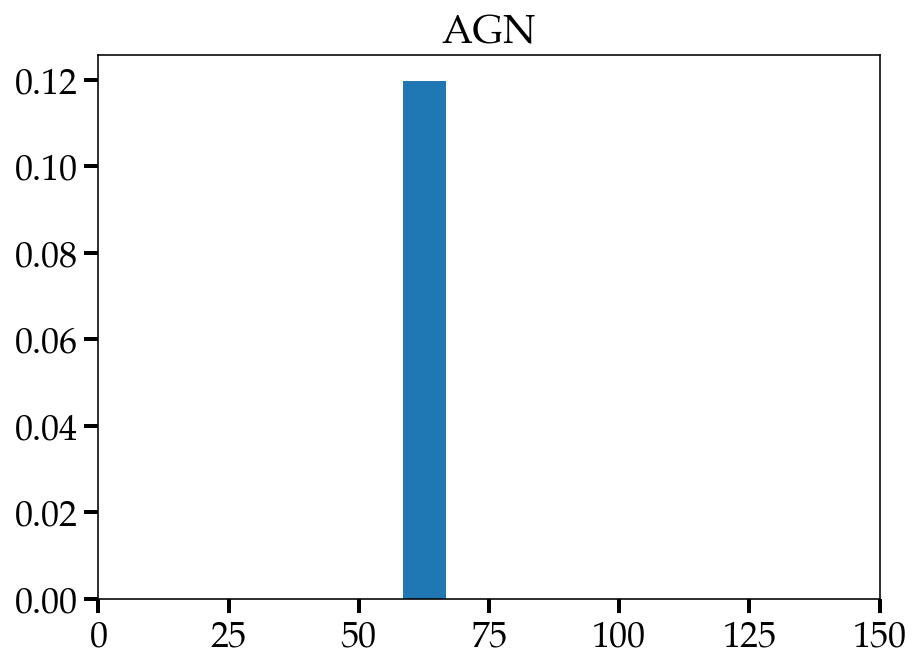

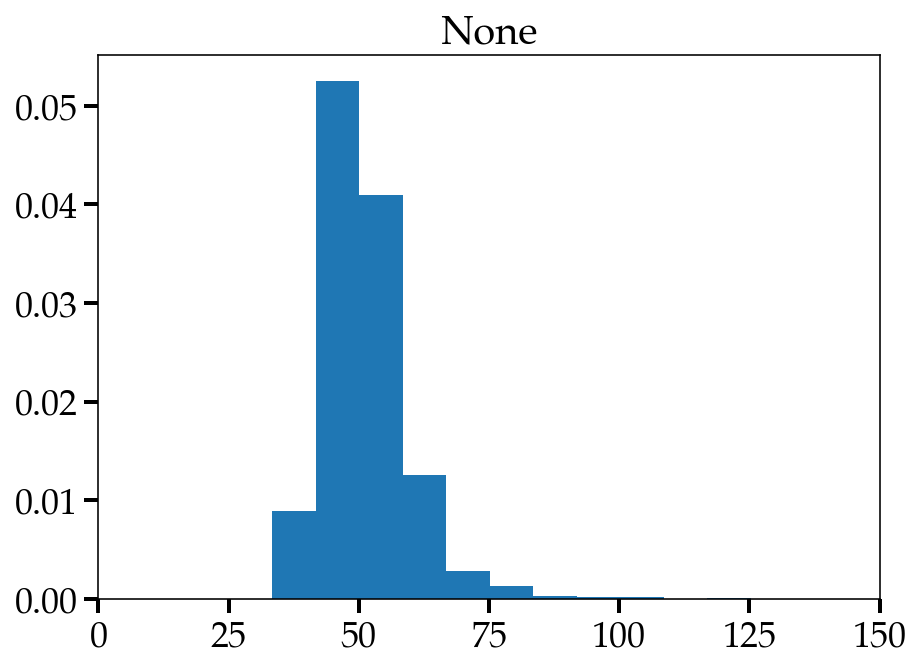

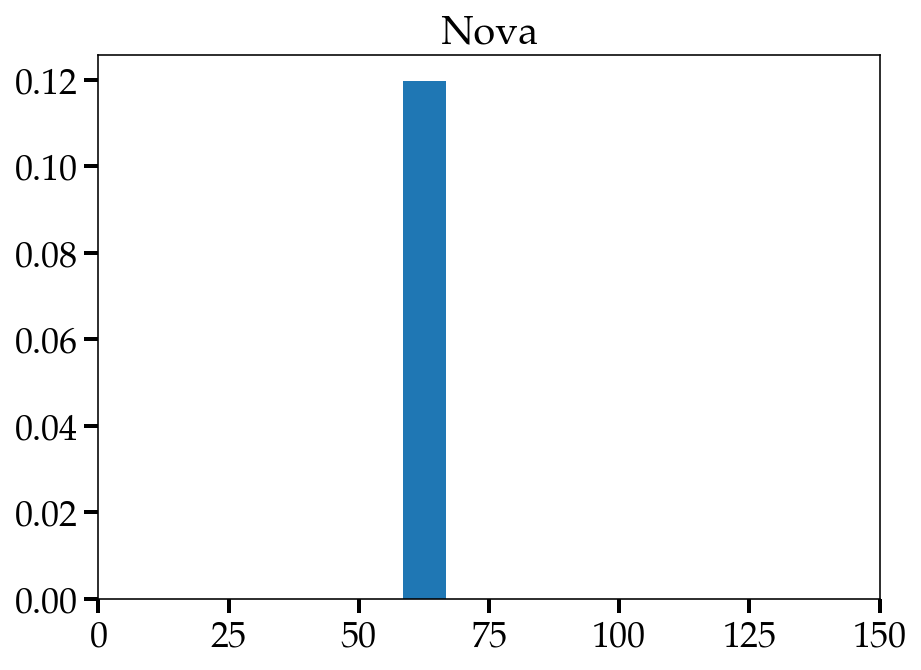

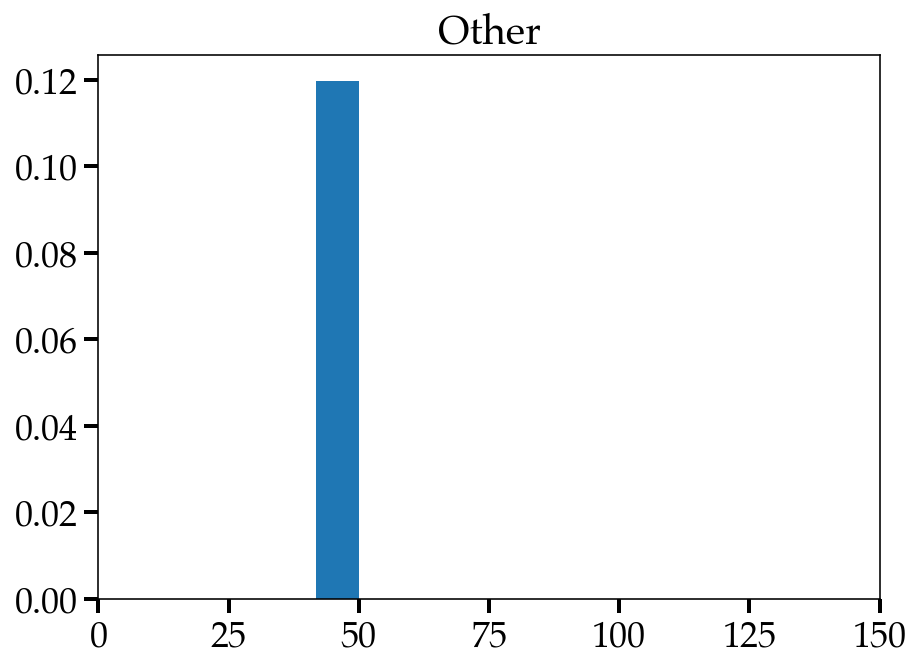

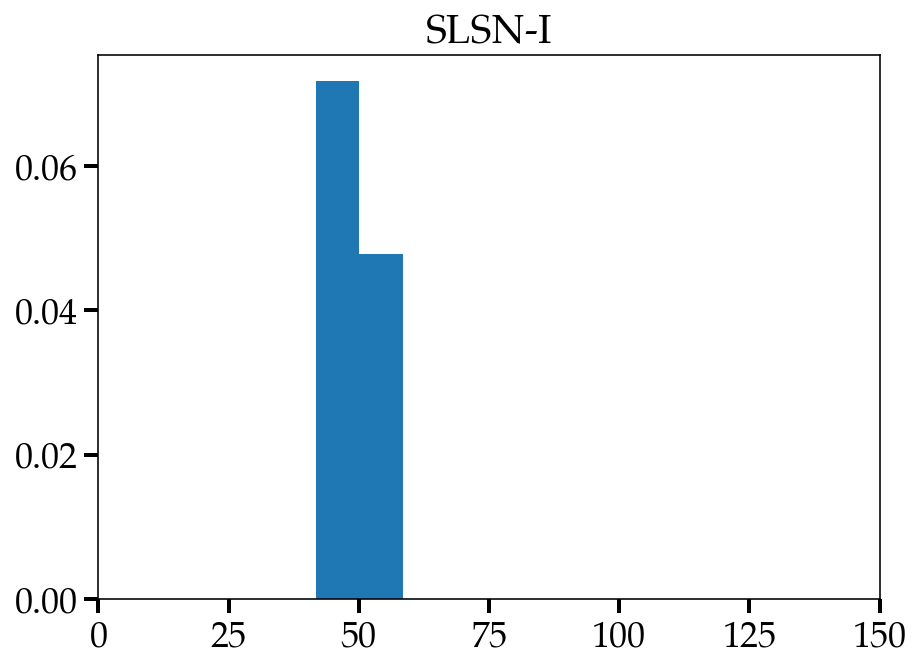

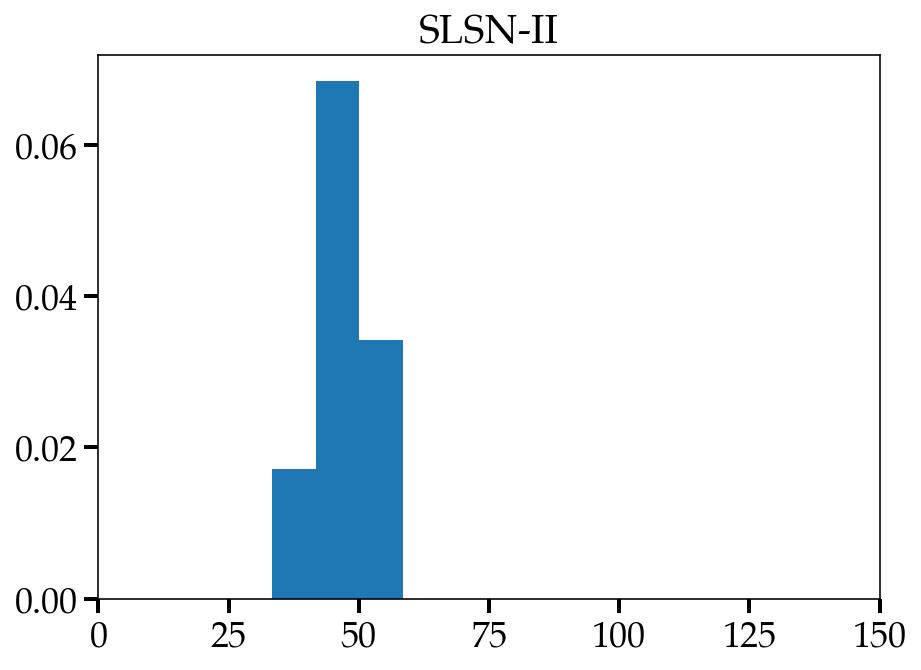

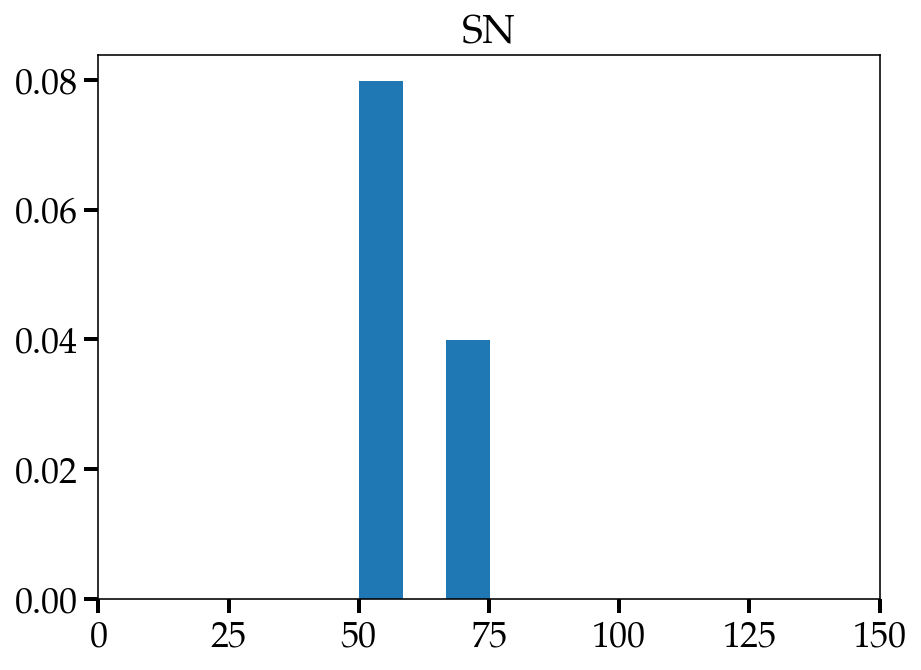

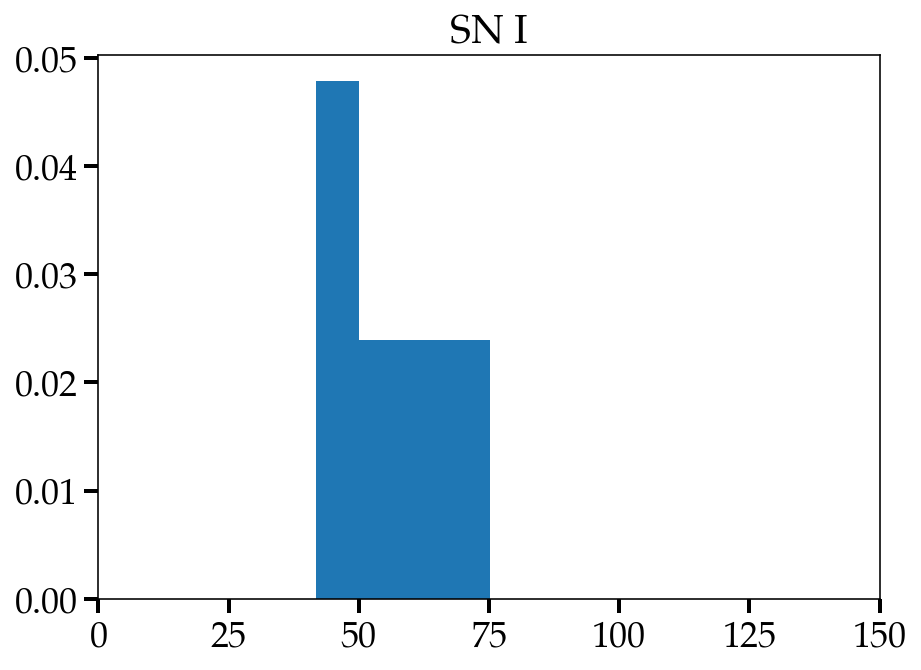

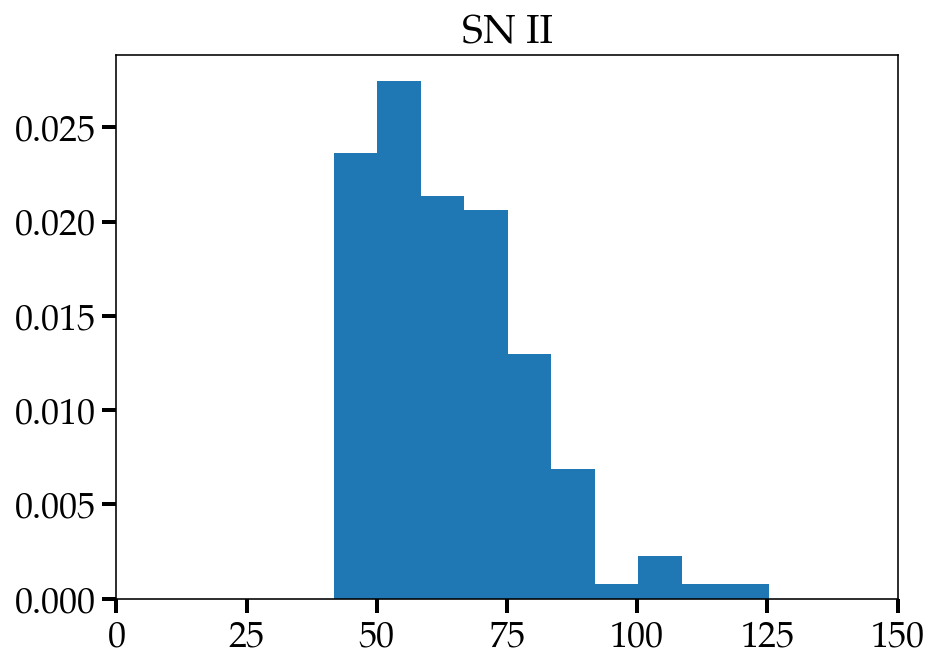

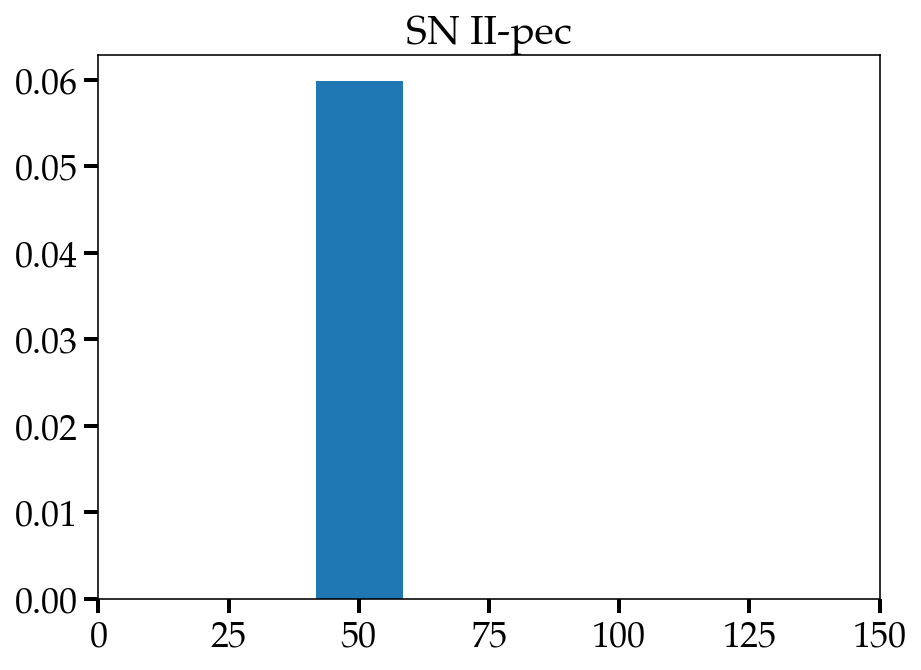

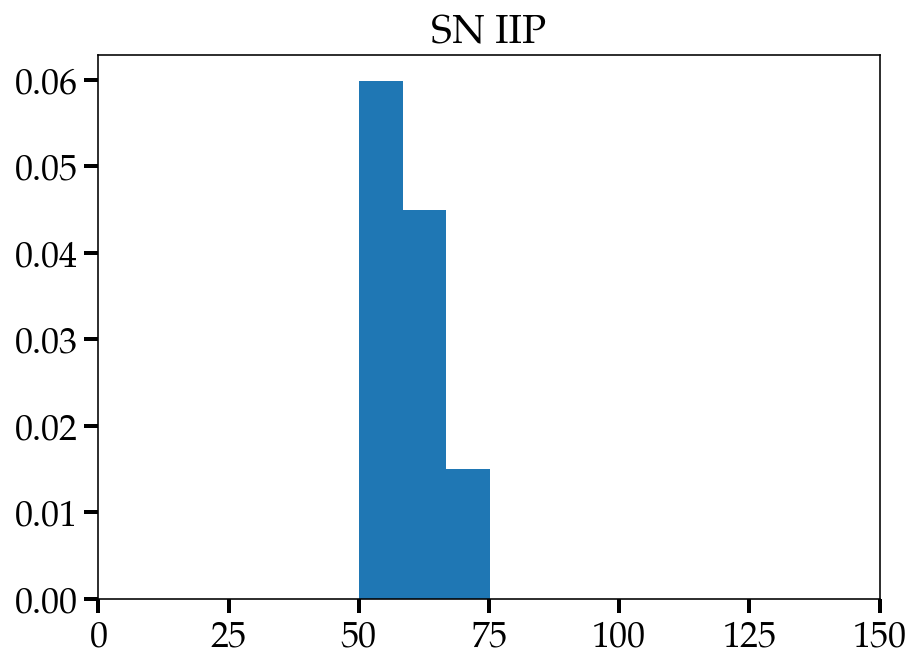

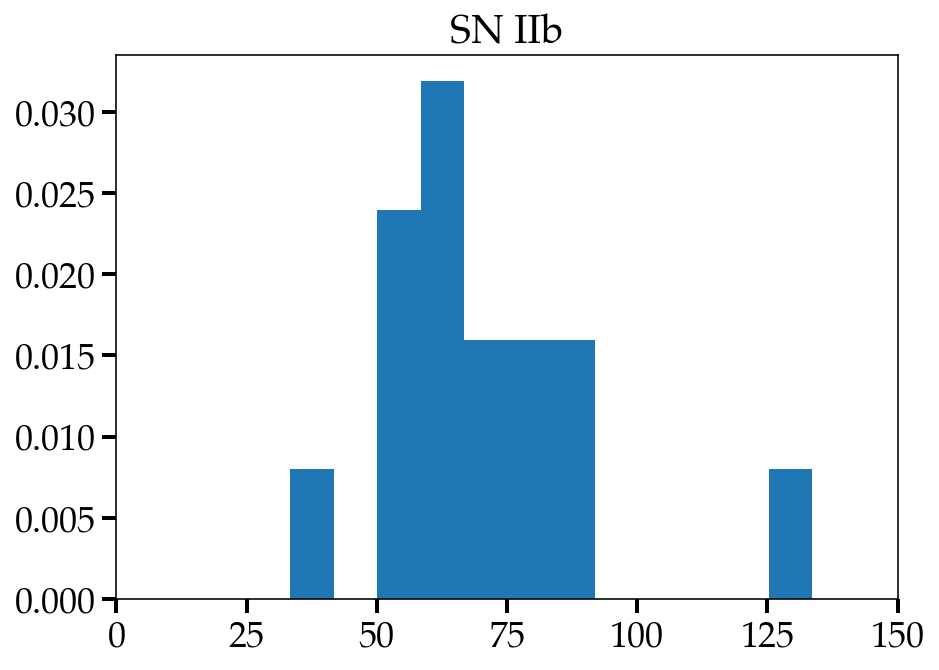

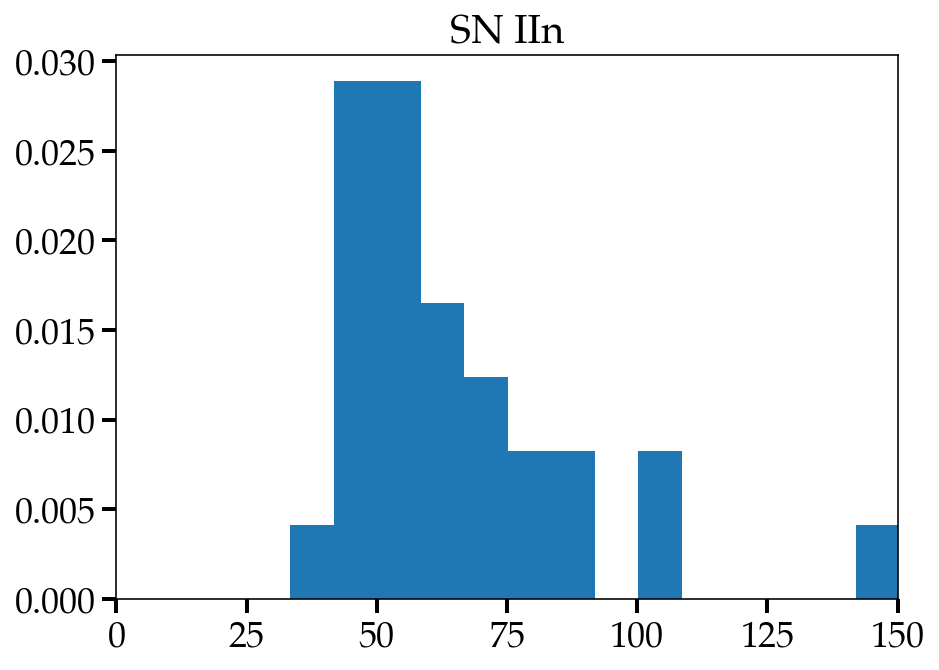

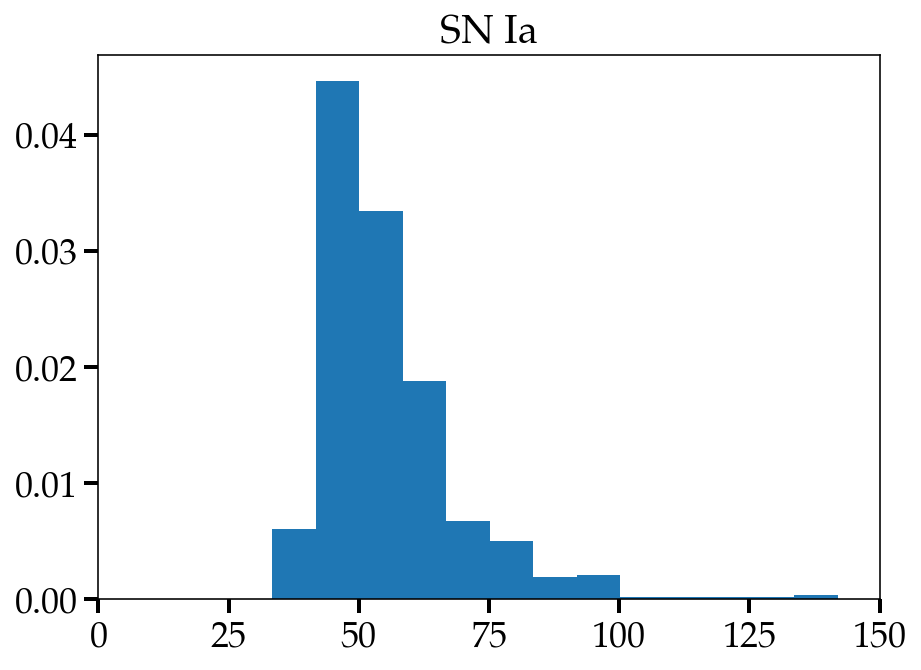

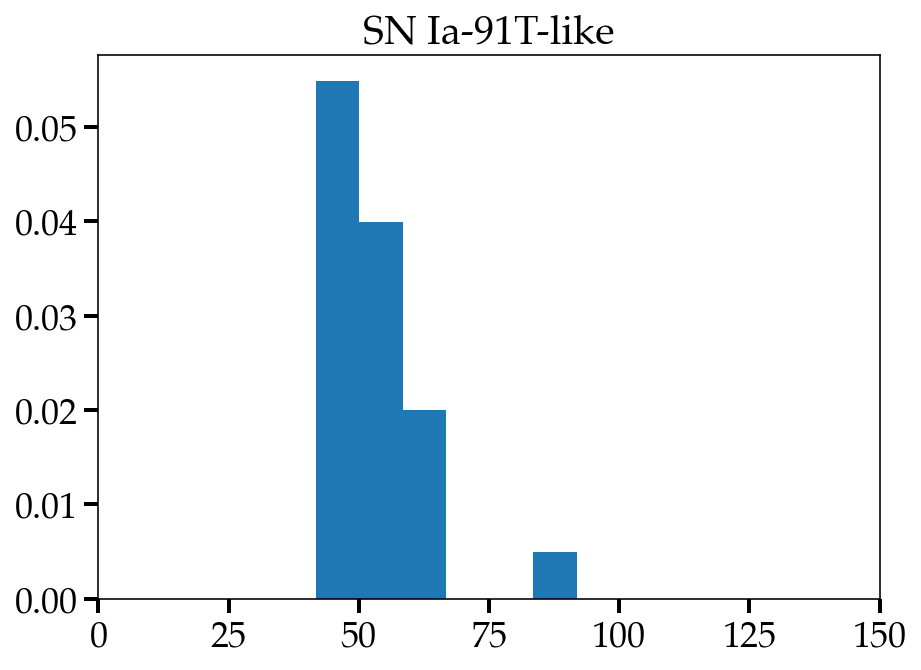

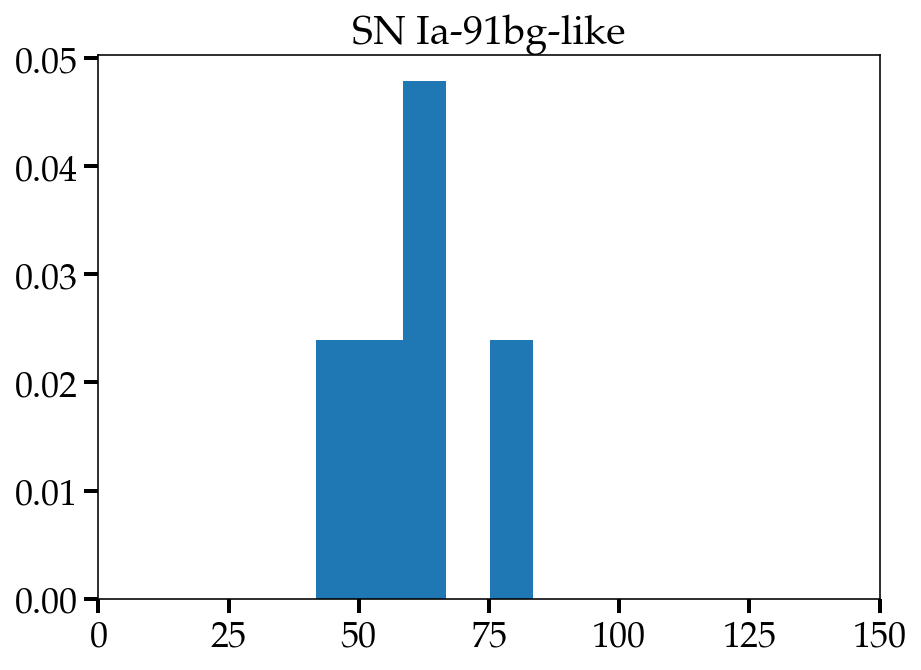

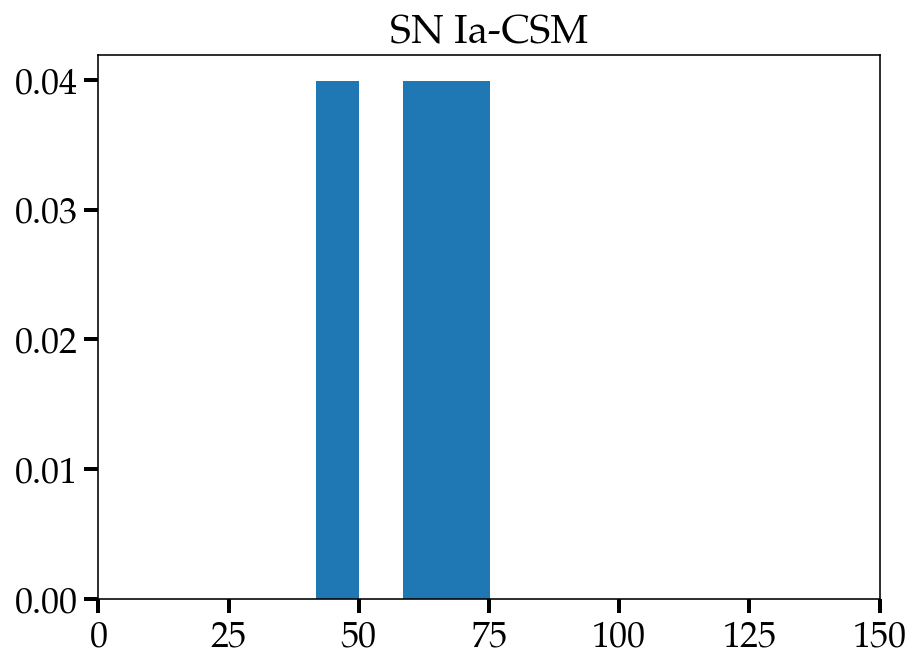

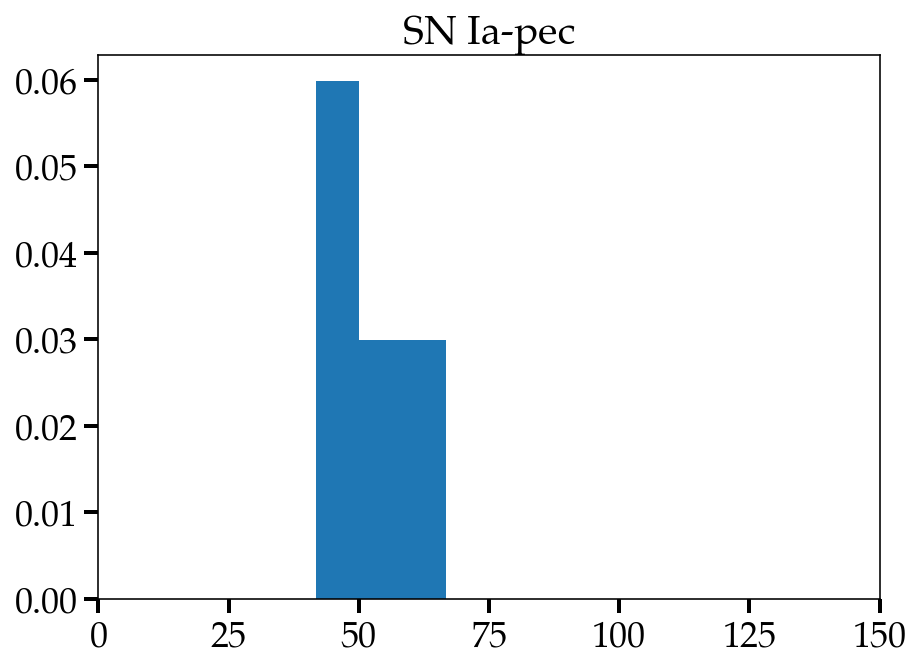

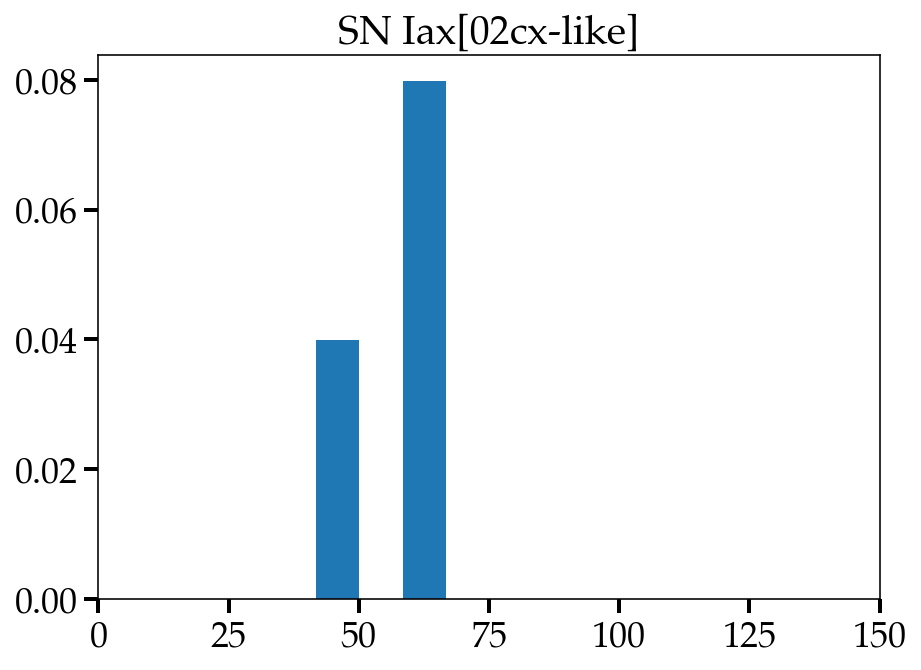

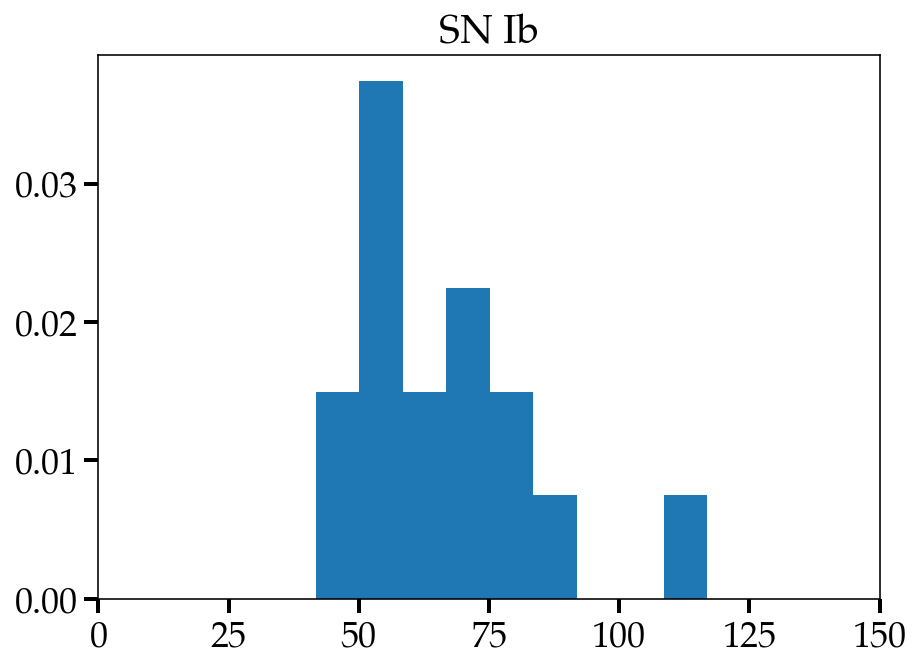

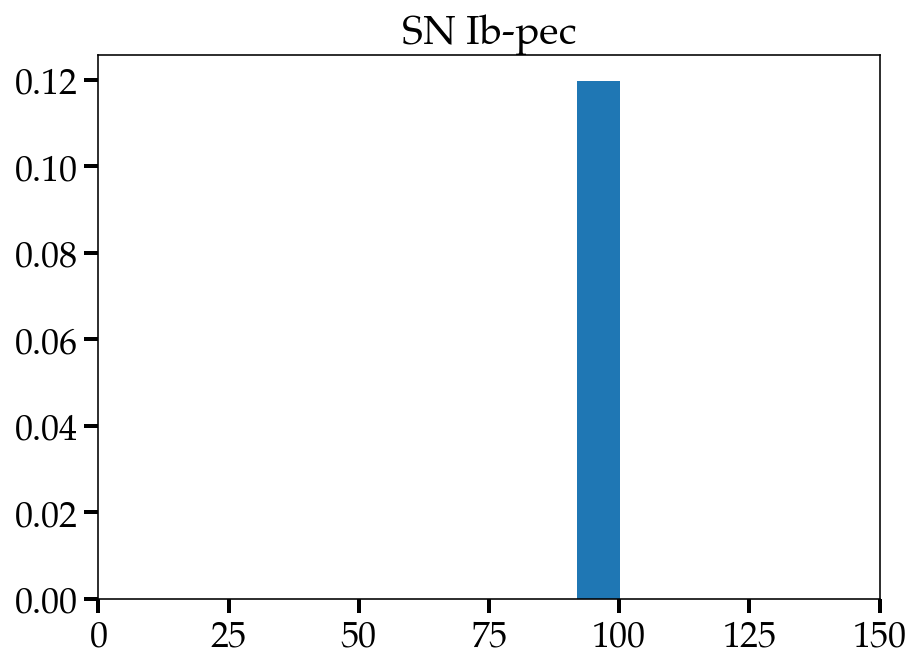

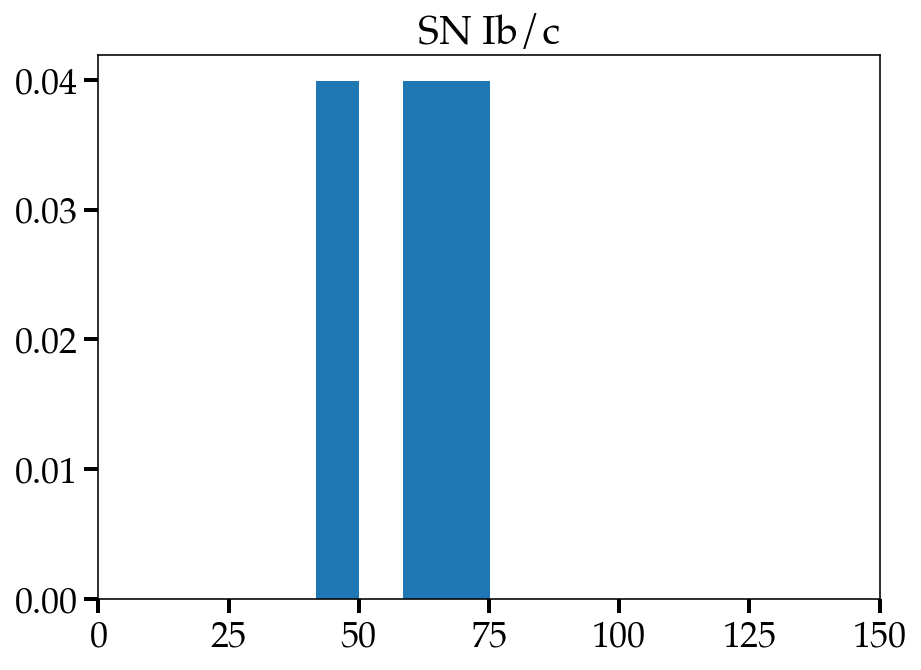

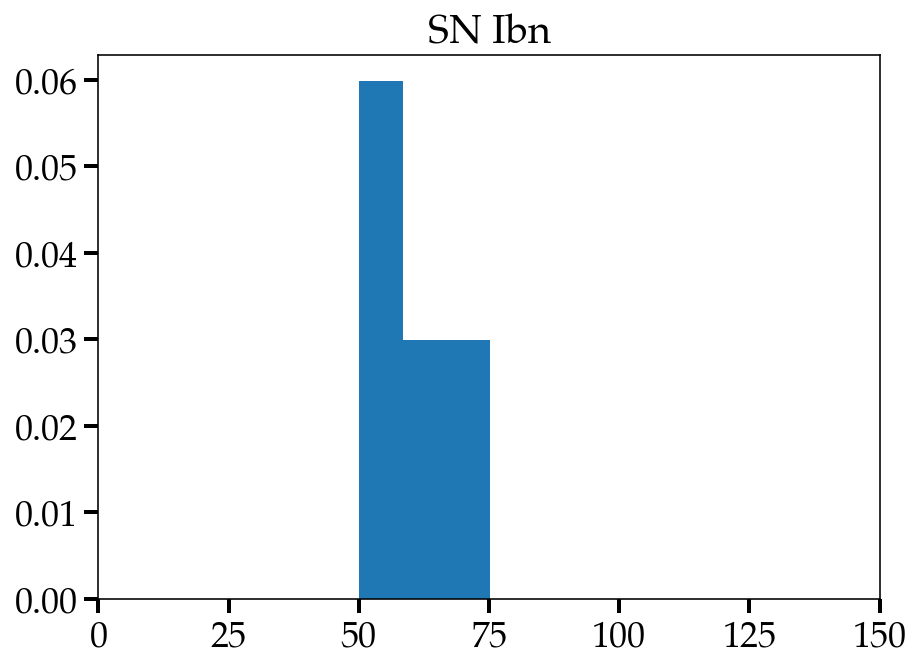

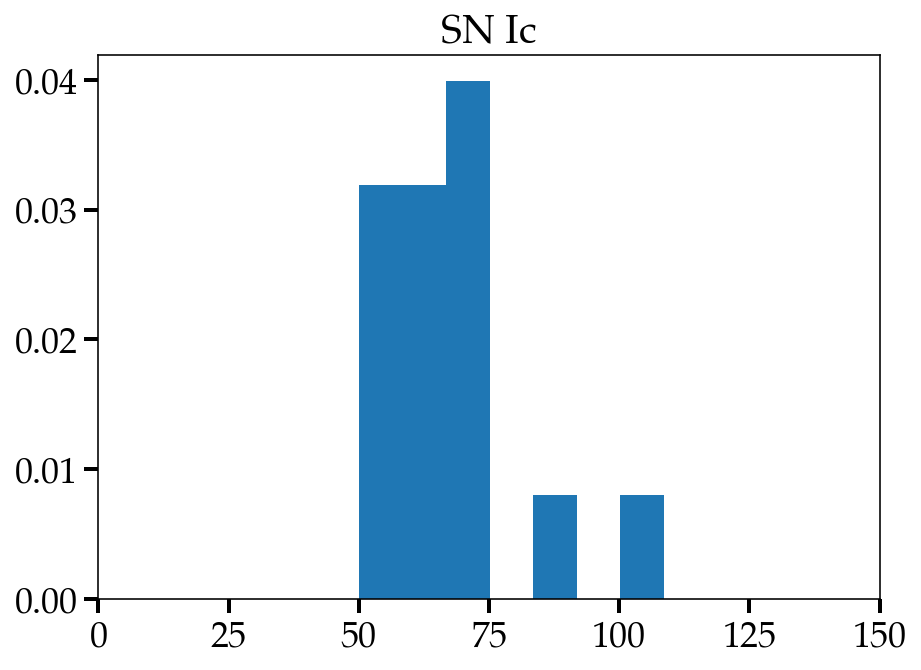

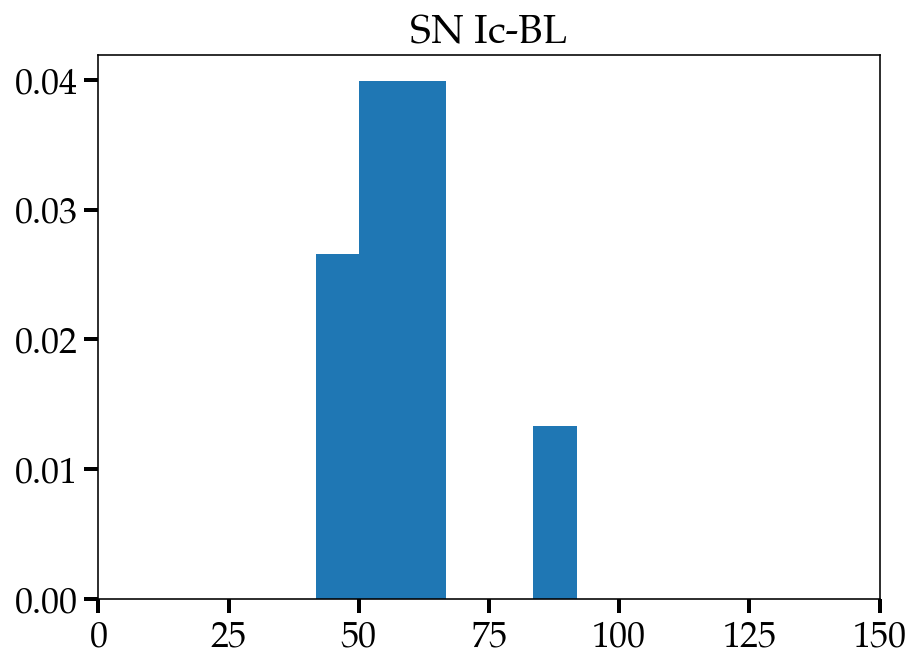

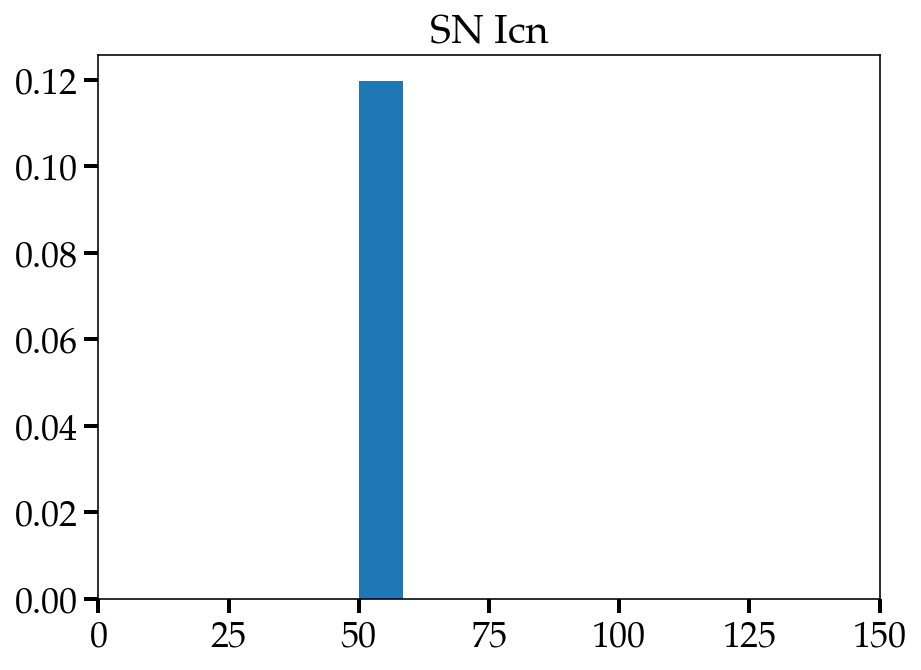

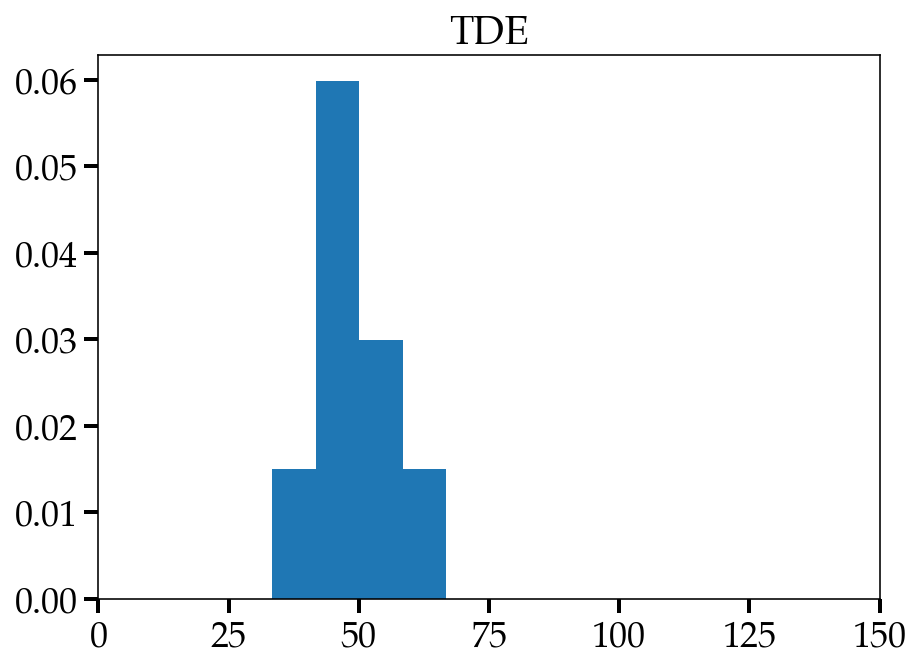

In [5]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    
    ax.set_title(cls)
    ax.set_xlim(0, 150)

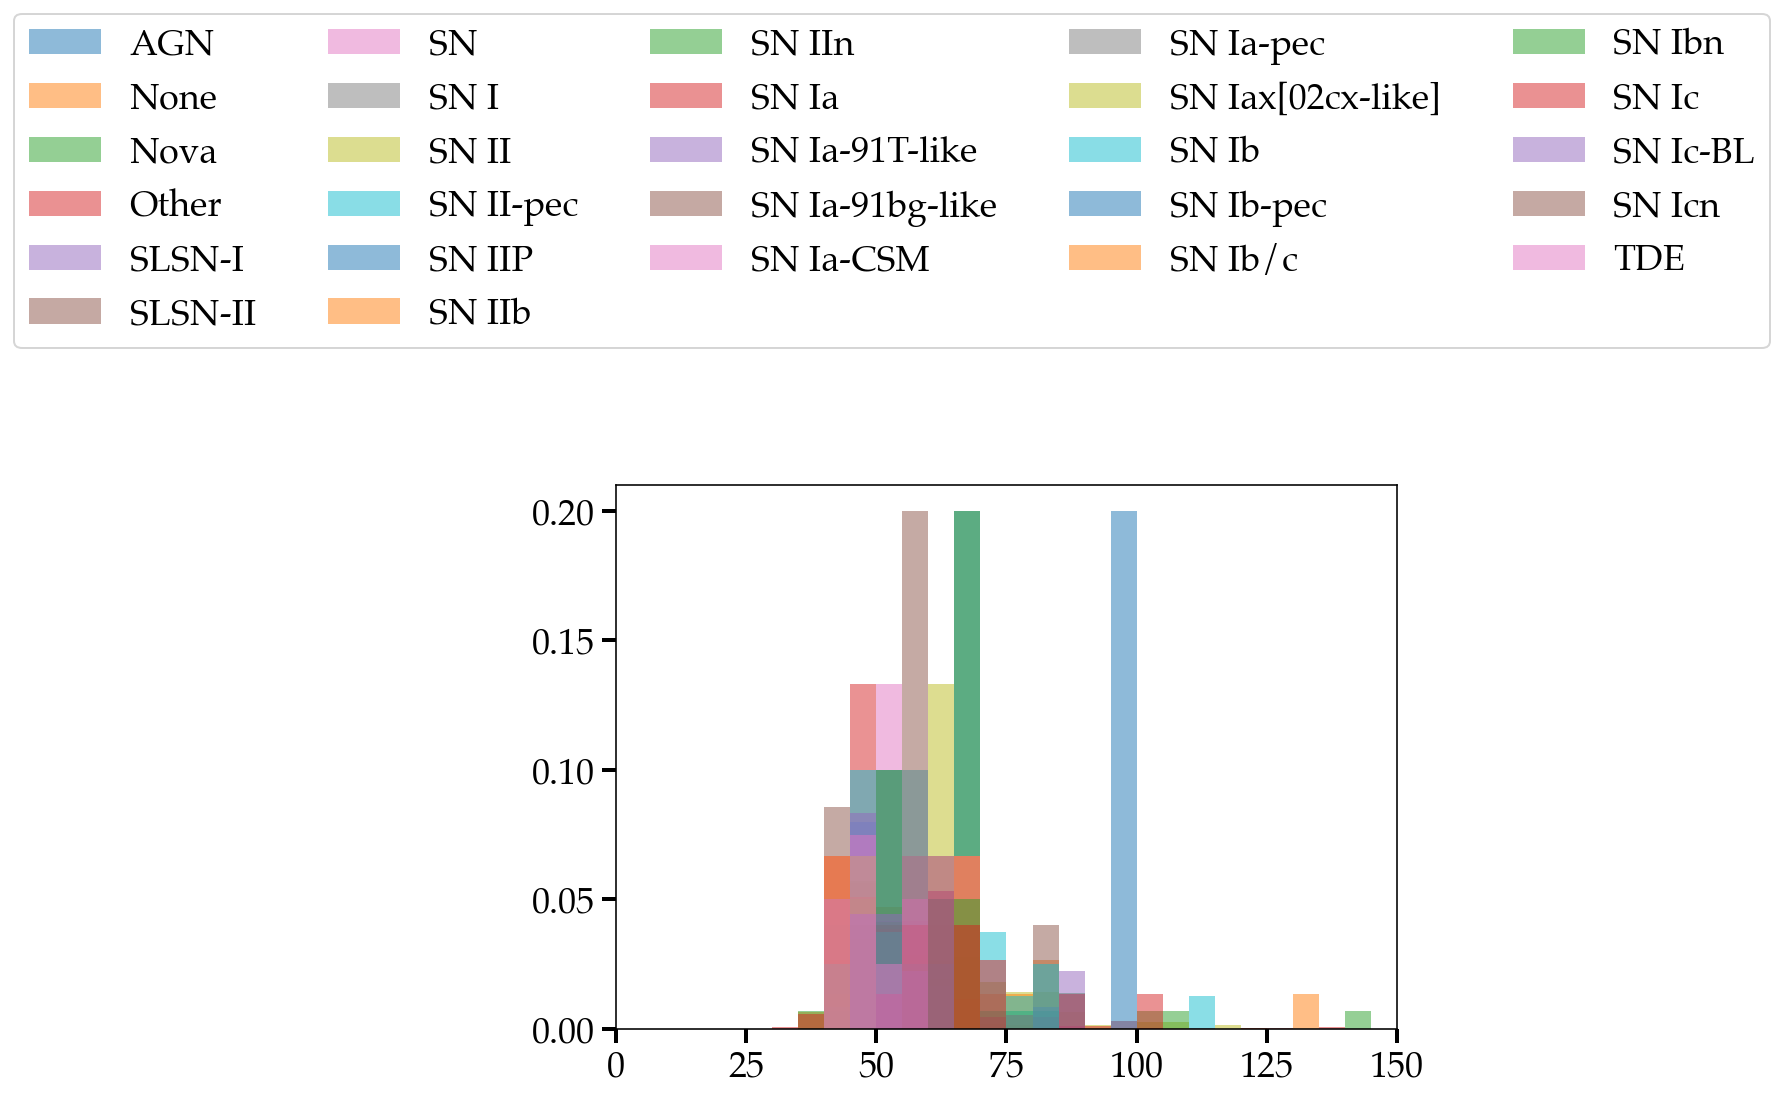

In [6]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(0, 150)
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

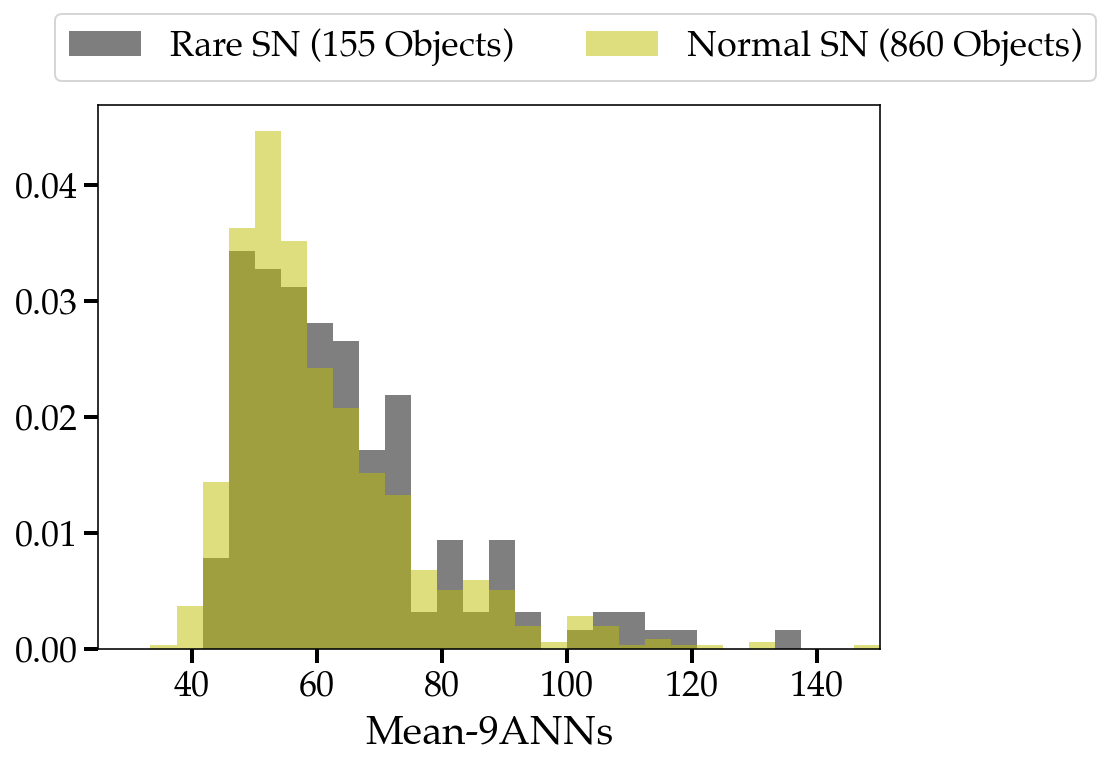

In [7]:
fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-9ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

In [8]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-9ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-9ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.14193548387096774
P-value: 0.1391944315113766
The two distributions are likely the same.


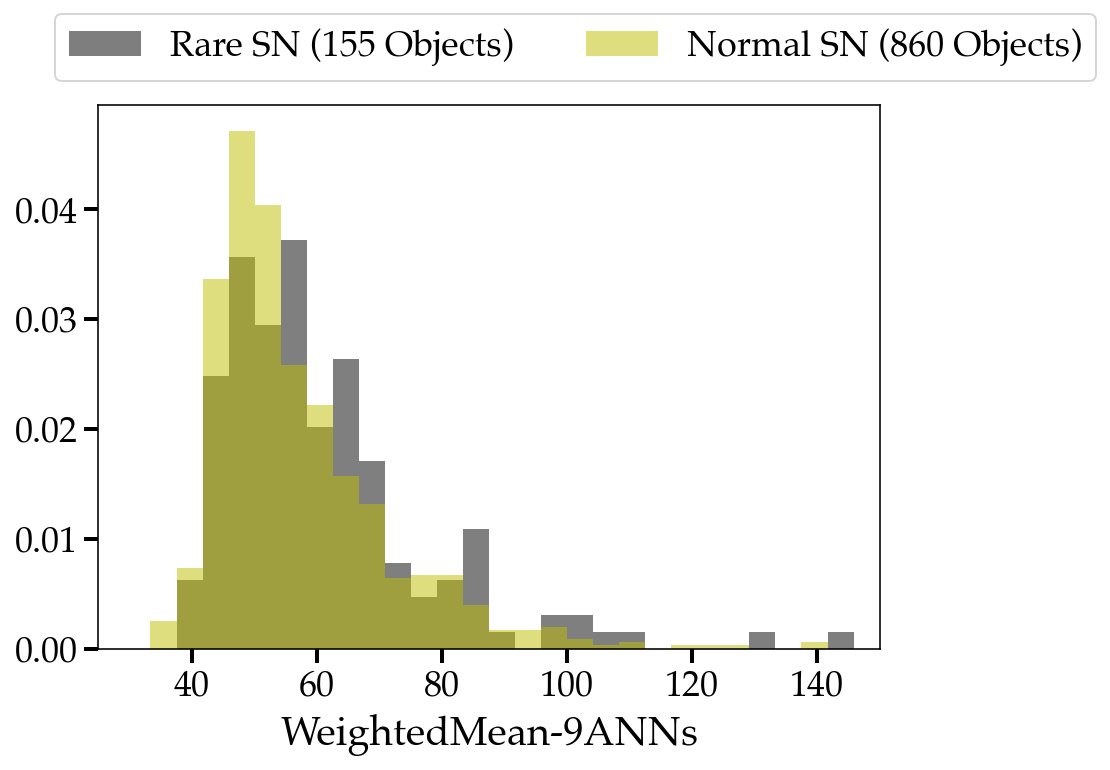

In [9]:
fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('WeightedMean-9ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_WeightedMean.png')
plt.show()

In [10]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["WeightedMean-9ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["WeightedMean-9ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.11612903225806452
P-value: 0.1002054442966859
The two distributions are likely the same.


## No statistical difference between Rare SN and Normal SN...

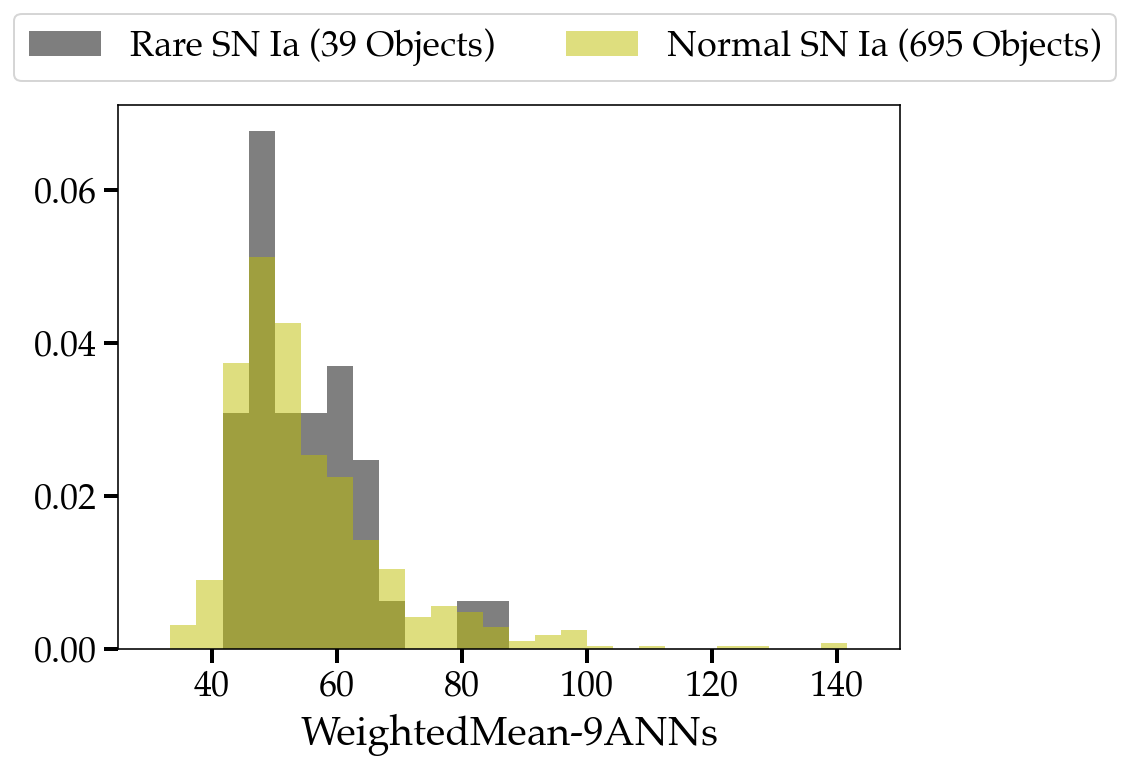

In [11]:
fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df["WeightedMean-9ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('WeightedMean-9ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_WeightedMean_Ia.png')
plt.show()

In [12]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df["WeightedMean-9ANNs"], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df["WeightedMean-9ANNs"], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.20512820512820512
P-value: 0.6104151640654834
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [13]:
suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,ZTF17aaahrni,ZTF21aarenhl,ZTF21abbzjeq,ZTF21aagycrc,ZTF20acnvlgg,ZTF20absvtnc,ZTF21abcgjpw,ZTF21aapkhsc,ZTF21abbliav,ZTF21aaprddk,...,-99.000,0.040000,0.043,0.068,0.070,0.035000,-99.000000,0.040000,0.049,0.053
1,ZTF17aadqidc,ZTF21aaannfk,ZTF21aaroiur,ZTF21aalklsu,ZTF21aaxkccg,ZTF20aciuftf,ZTF21abuunol,ZTF21aarzqri,ZTF21aarwgjb,ZTF21aaxtufg,...,-99.000,-99.000000,-99.000,-99.000,-99.000,0.130000,-99.000000,-99.000000,-99.000,-99.000
2,ZTF18aabdnbr,ZTF20actoabw,ZTF21abainqp,ZTF21abdaxai,ZTF21abdwpzy,ZTF21aajtqmv,ZTF21aaogiic,ZTF21abewpao,ZTF19aaaamwp,ZTF21aalvdng,...,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3,ZTF18aabeszt,ZTF21aabvqlo,ZTF21aaydwzt,ZTF20acowddo,ZTF20acpkled,ZTF20actfeym,ZTF21aawlwoy,ZTF21aanyfqu,ZTF21aaxtrlt,ZTF20acrerzb,...,0.081,0.080178,NaN,0.073,0.091,0.055905,0.050320,0.067158,0.080,0.070
4,ZTF18aabvmws,ZTF18aahfbqp,ZTF18acsxjhc,ZTF21aawihwx,ZTF18aamxjoa,ZTF19aabyhwy,ZTF21abfiuqf,ZTF20acnznol,ZTF18acuimze,ZTF19aamdmcs,...,-99.000,0.041362,-99.000,0.044,-99.000,-99.000000,0.023646,0.032312,0.056,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3623,ZTF21ackmpcb,ZTF18acevgyz,ZTF20acpqxsz,ZTF21aatshso,ZTF21aauvbjh,ZTF21aasjilo,ZTF21ackwyaz,ZTF20acpyndh,ZTF21aawjipb,ZTF18acbzvow,...,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3624,ZTF21ackwyaz,ZTF21abwbmxq,ZTF21abdgbie,ZTF21aazlqij,ZTF21aaxvxbu,ZTF21ackmpcb,ZTF21aaiqdbp,ZTF21aakitay,ZTF21aasjilo,ZTF21aawjipb,...,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3625,ZTF21ackzfeh,ZTF21aazoger,ZTF21aaqyenr,ZTF20aclczrv,ZTF21abqljmq,ZTF18acvggdb,ZTF21aatiolj,ZTF21aaxtshx,ZTF21abvdcep,ZTF21aatjhqe,...,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3626,ZTF21acldmwy,ZTF21aauakph,ZTF20aclmssm,ZTF19aacislx,ZTF21aarxbac,ZTF21abmzzxa,ZTF19aayuxpq,ZTF21aanzmoi,ZTF20acmpkpr,ZTF21aatlfdp,...,0.110,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000


In [14]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 30:40]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
0,None,SN Ia-pec,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia
1,None,None,None,None,None,SN Ia,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None
3,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia
4,None,SN Ia,None,SN Ia-91bg-like,None,None,SN II,SN Ia,SN Ia,SN Ia
...,...,...,...,...,...,...,...,...,...,...
3623,None,None,None,None,None,None,None,None,None,None
3624,None,None,None,None,None,None,None,None,None,None
3625,None,None,None,None,None,None,None,None,None,None
3626,SN Ia,None,None,None,None,None,None,None,None,None


In [15]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 40:50]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,-99.000,0.040000,0.043,0.068,0.070,0.035000,-99.000000,0.040000,0.049,0.053
1,-99.000,-99.000000,-99.000,-99.000,-99.000,0.130000,-99.000000,-99.000000,-99.000,-99.000
2,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3,0.081,0.080178,NaN,0.073,0.091,0.055905,0.050320,0.067158,0.080,0.070
4,-99.000,0.041362,-99.000,0.044,-99.000,-99.000000,0.023646,0.032312,0.056,0.041
...,...,...,...,...,...,...,...,...,...,...
3623,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3624,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3625,-99.000,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000
3626,0.110,-99.000000,-99.000,-99.000,-99.000,-99.000000,-99.000000,-99.000000,-99.000,-99.000


In [16]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 10)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
0,None,"[SN Ia-pec, SN Ia, SN Ia, SN Ia, SN Ia, None, ..."
1,None,"[None, None, None, None, SN Ia, None, None, No..."
2,None,"[None, None, None, None, None, None, None, Non..."
3,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
4,None,"[SN Ia, None, SN Ia-91bg-like, None, None, SN ..."
...,...,...
3623,None,"[None, None, None, None, None, None, None, Non..."
3624,None,"[None, None, None, None, None, None, None, Non..."
3625,None,"[None, None, None, None, None, None, None, Non..."
3626,SN Ia,"[None, None, None, None, None, None, None, Non..."


In [17]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ibn']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
1855,SN Ibn,None,None,None,None,None,SN Ia,None,None,None
2062,SN Ibn,SN Ia-91T-like,SN Ia,None,None,SN Ia,None,None,None,SN Ia
2213,SN Ibn,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN II,SN Ia,SN Ia
2640,SN Ibn,None,SN Ia,None,None,SN Ib,None,SN II,None,SN Ia


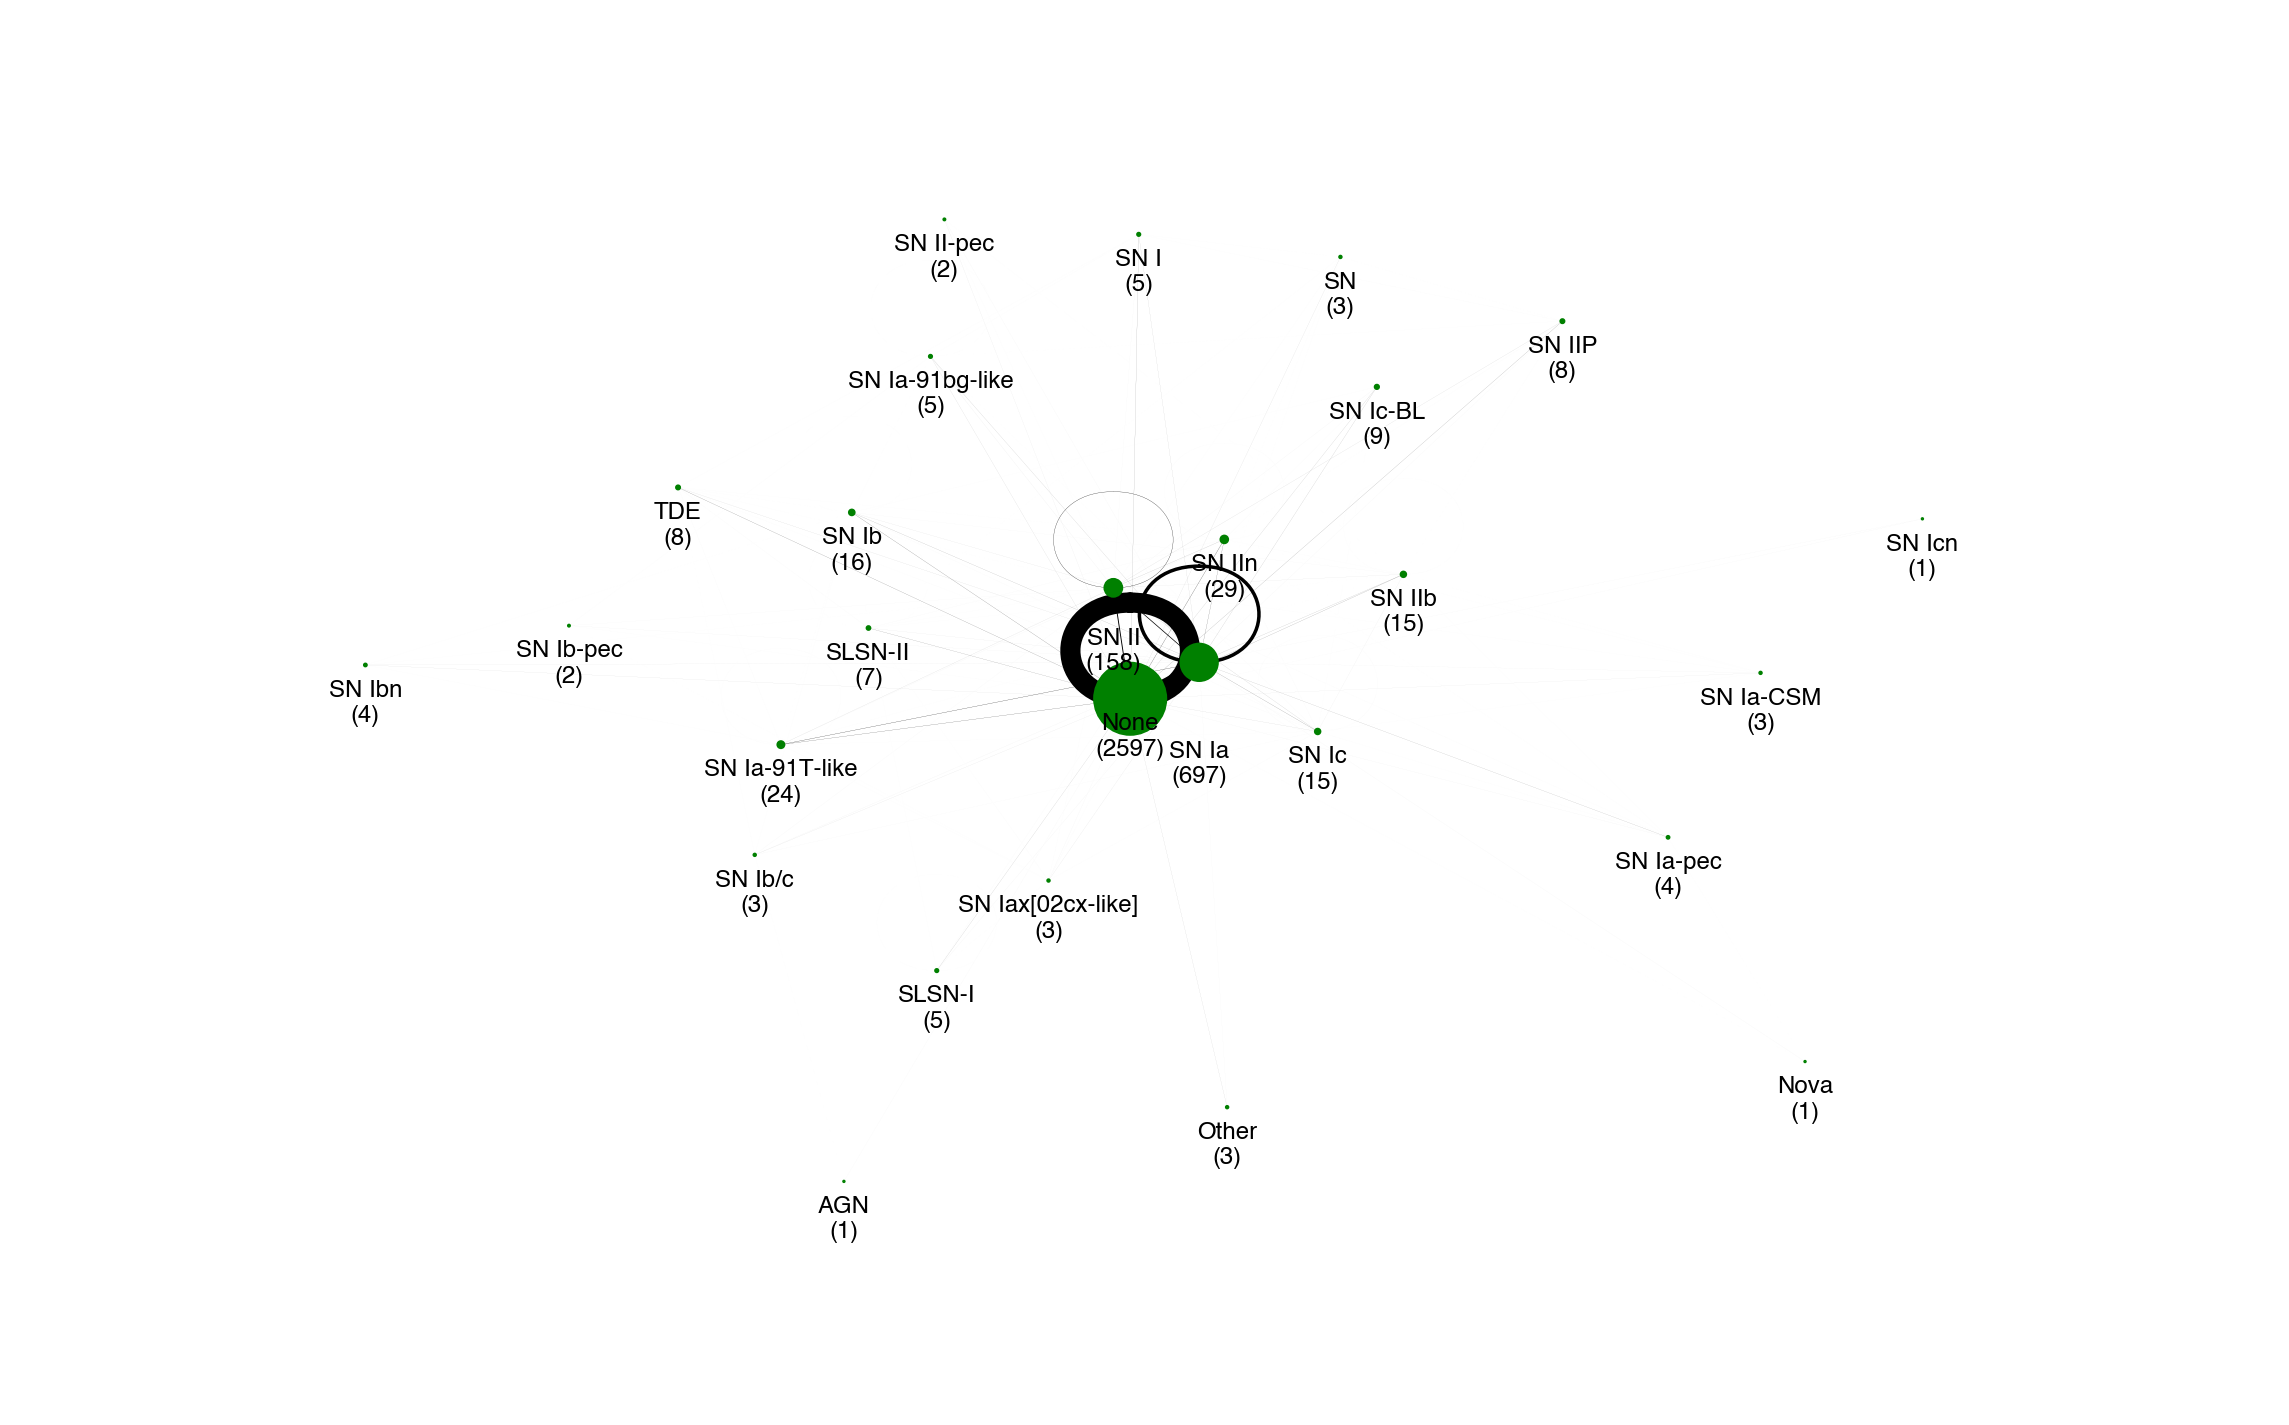

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/2000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        
node_sizes = [node_count[node] * 0.5 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# count the number of times of each node 
node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n\n\n\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}

node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig(f'../figures/graphs/{suffix}_size_scaled.jpg', dpi=300)
plt.show()


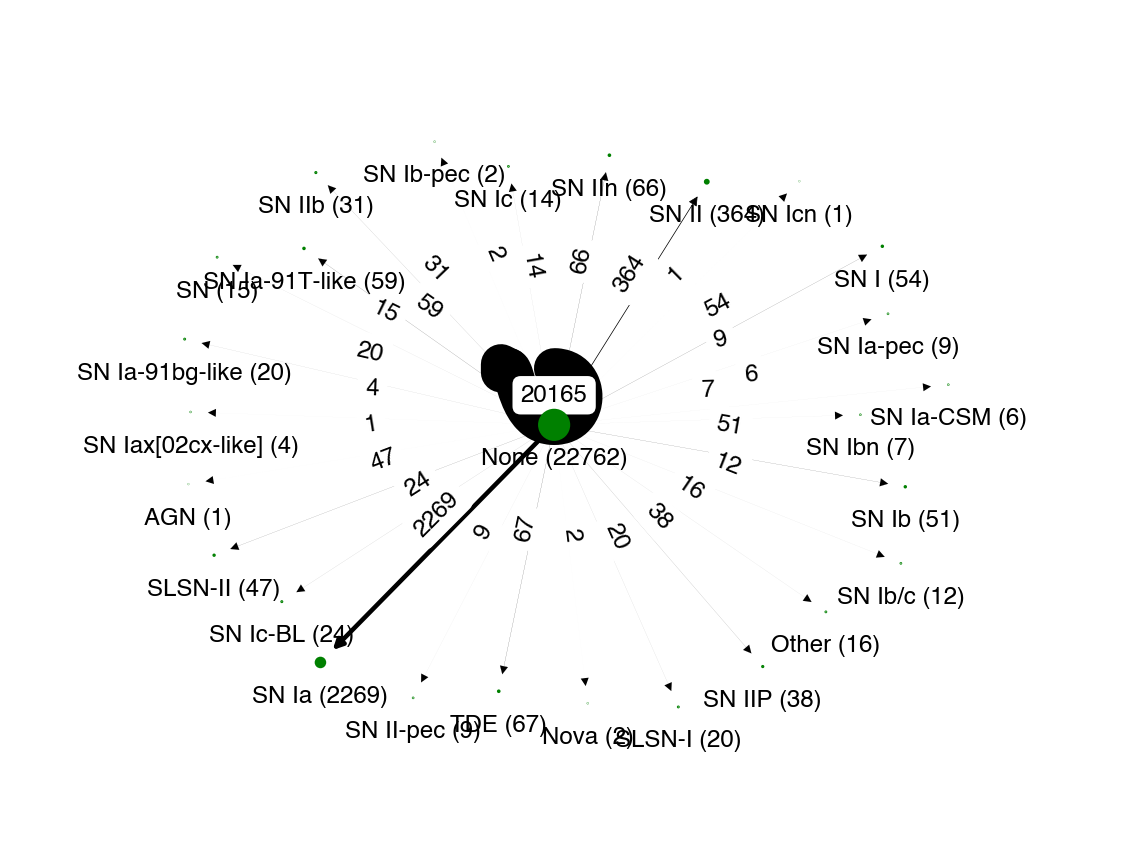

In [19]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


AGN


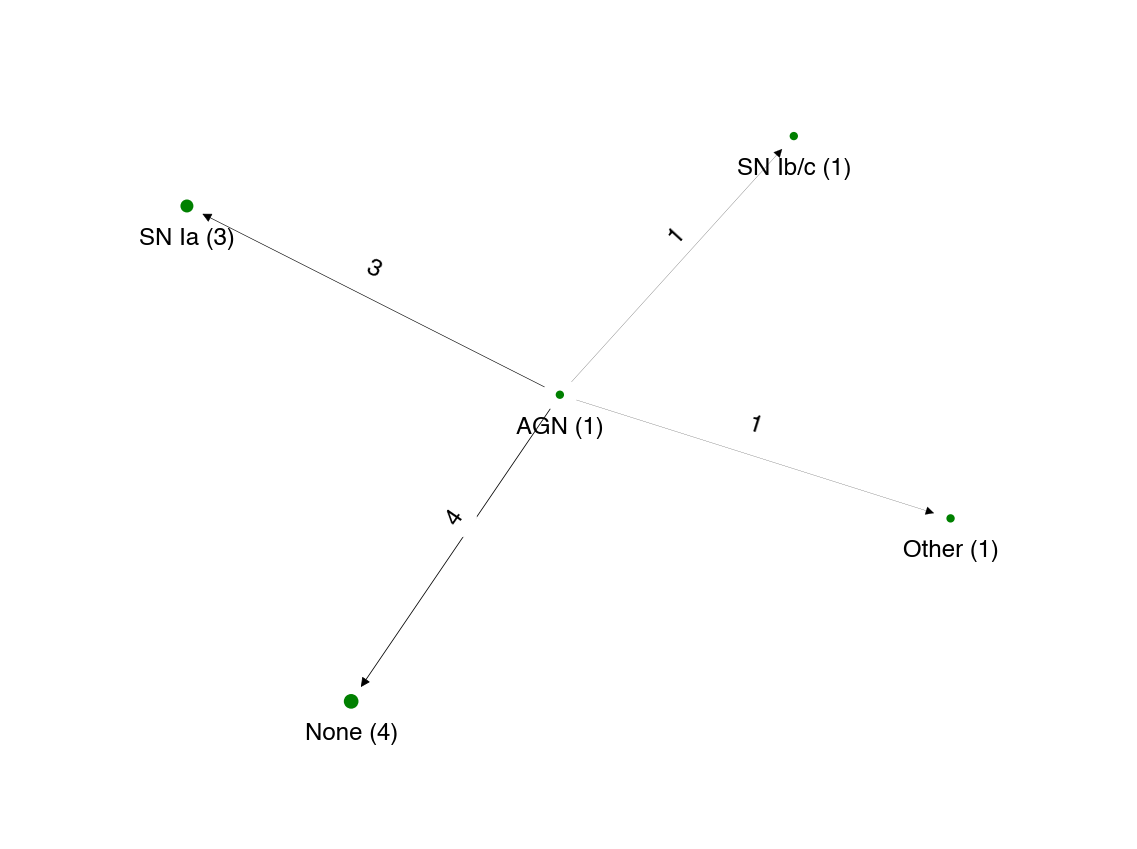

None


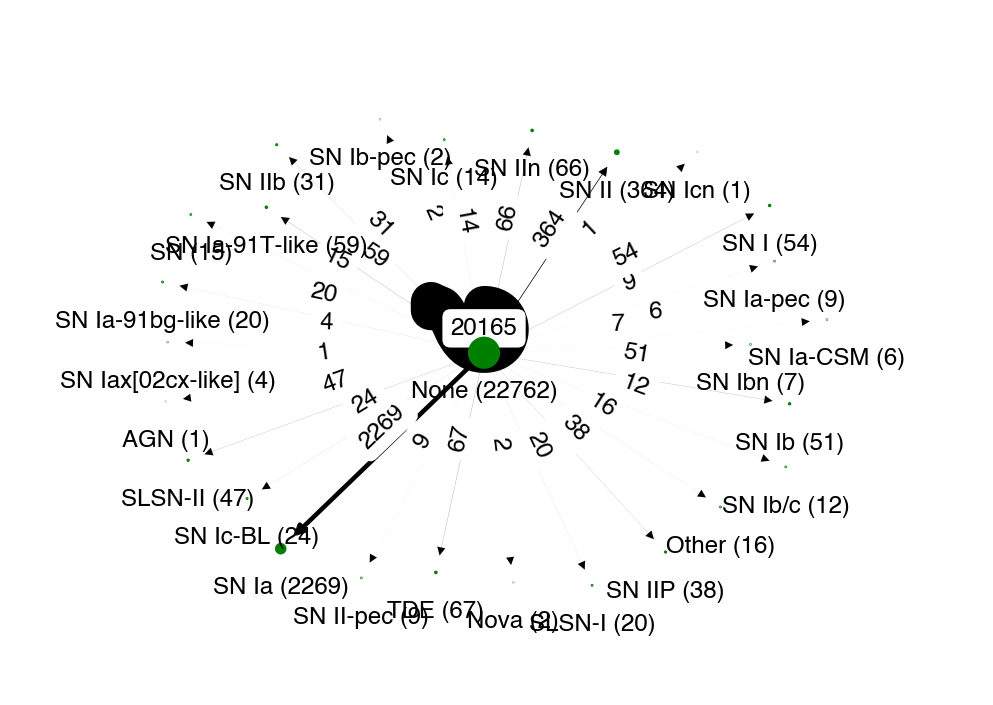

Nova


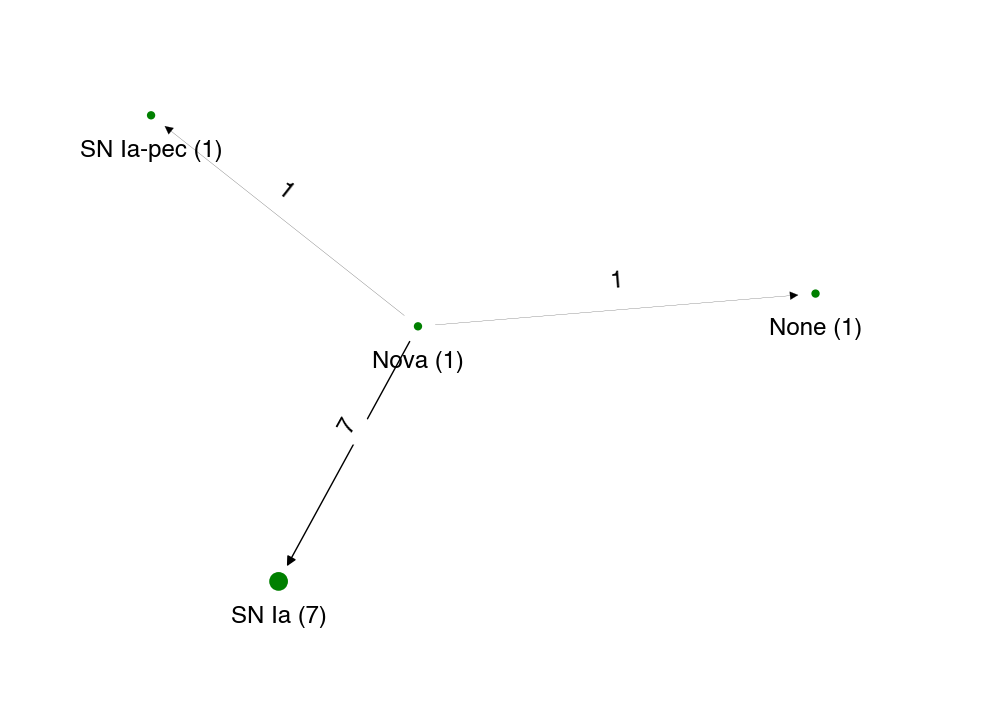

Other


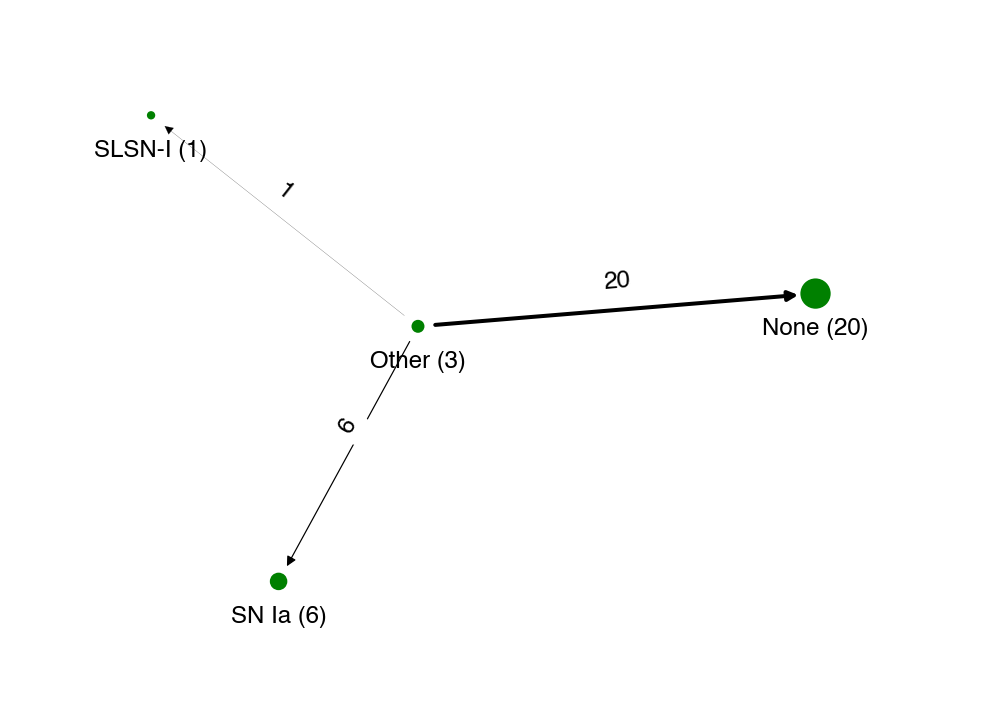

SLSN-I


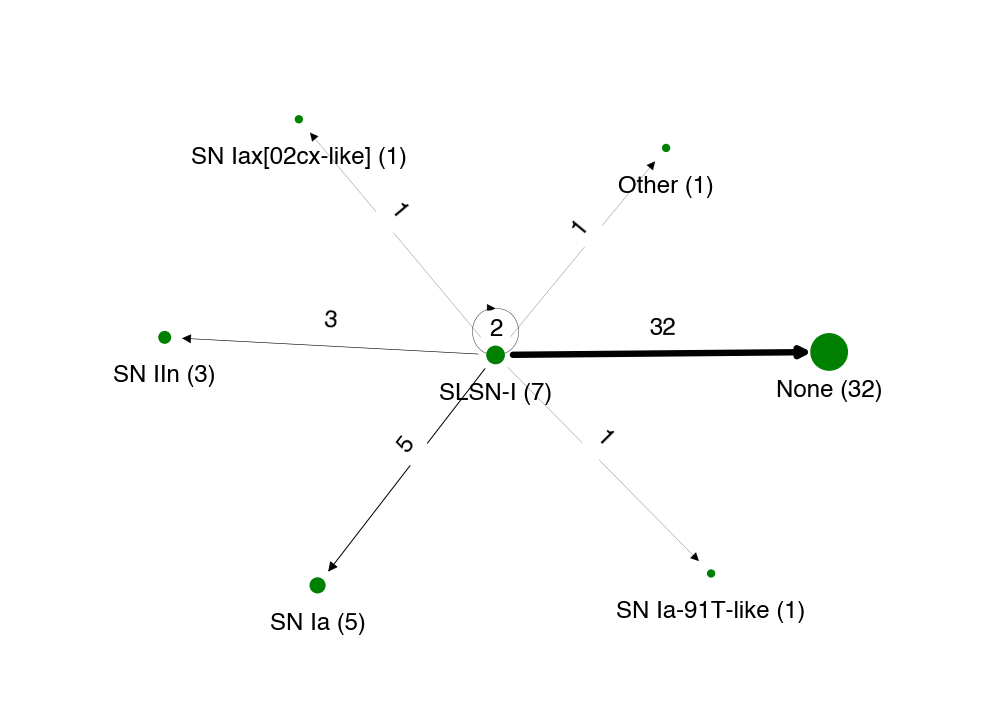

SLSN-II


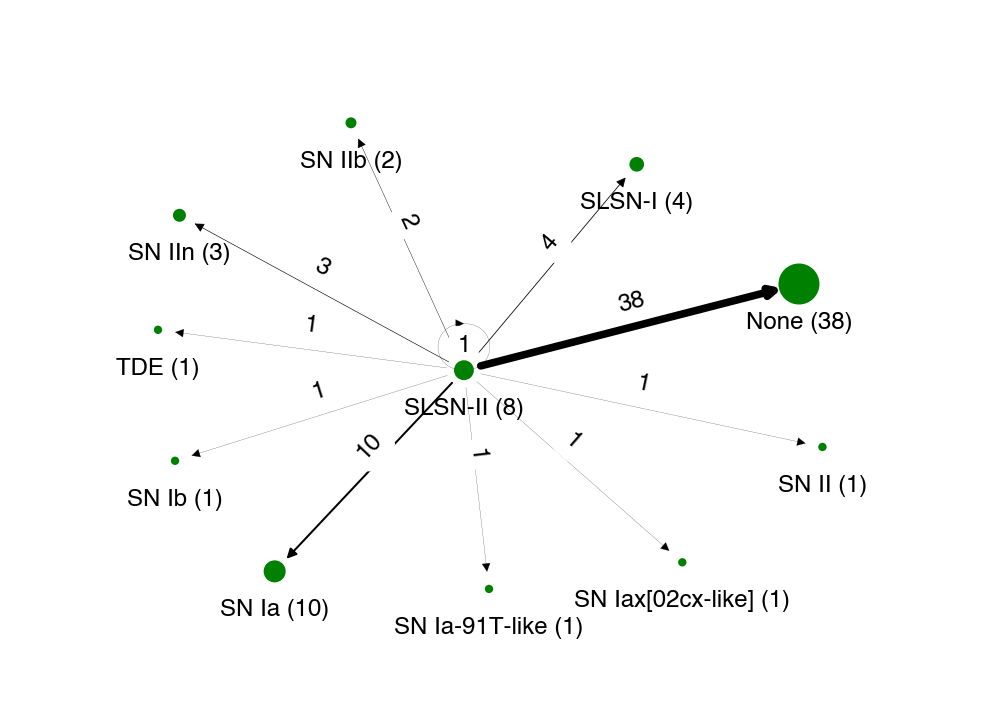

SN


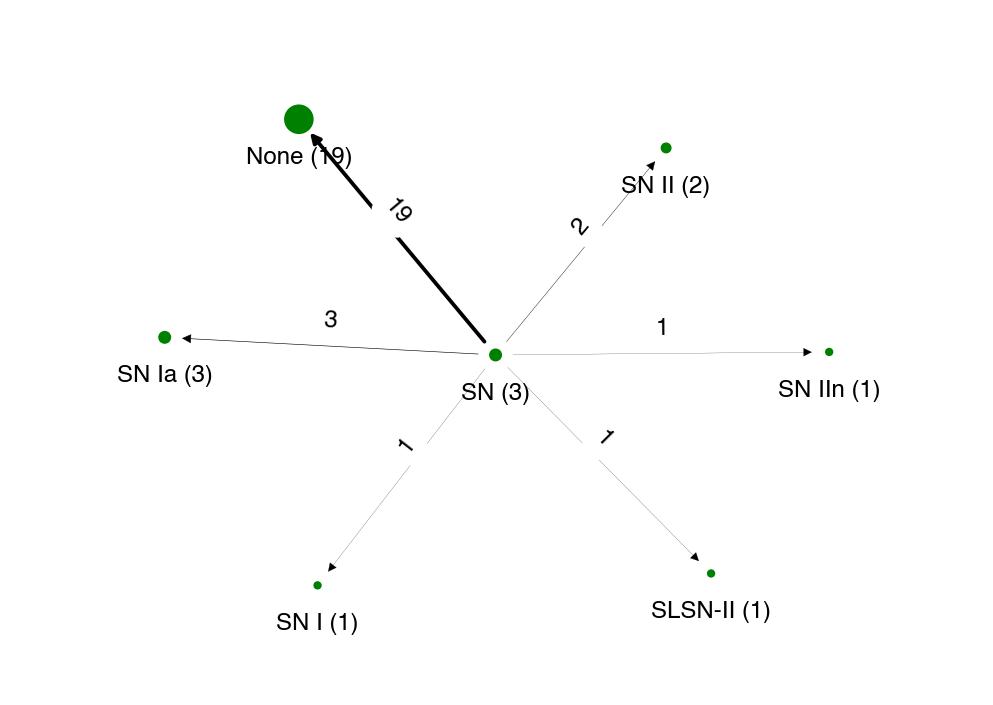

SN I


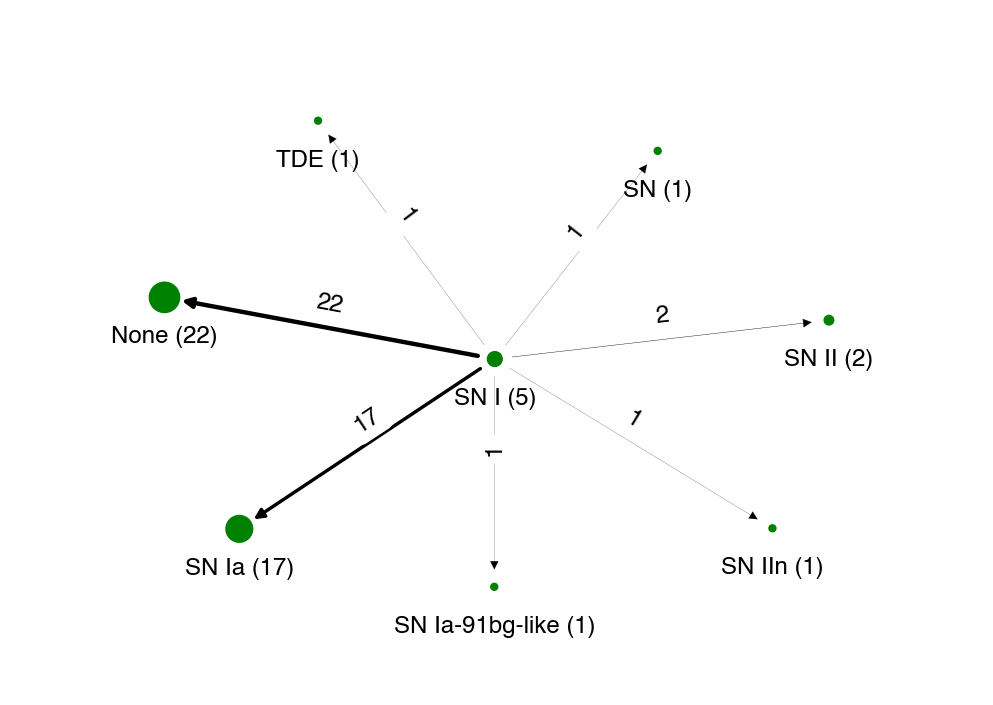

SN II


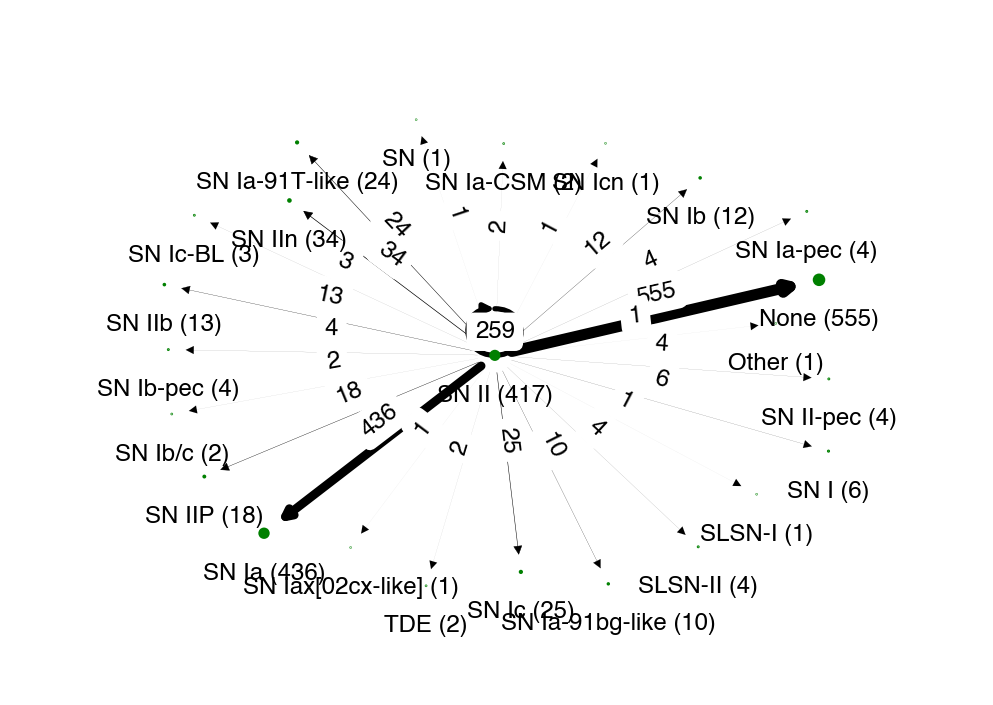

SN II-pec


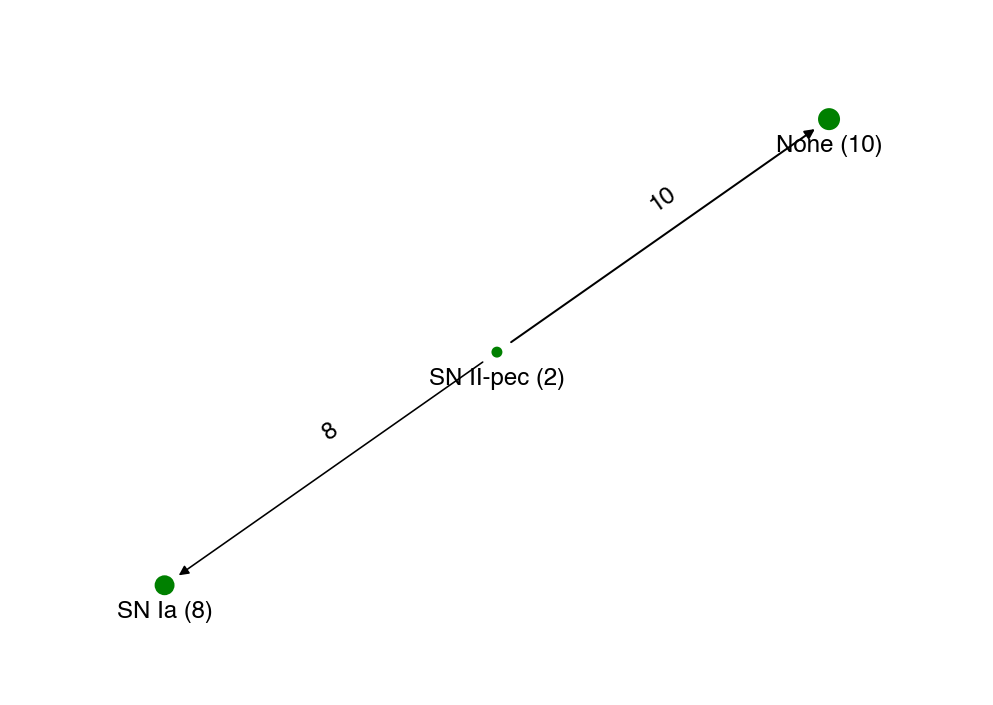

SN IIP


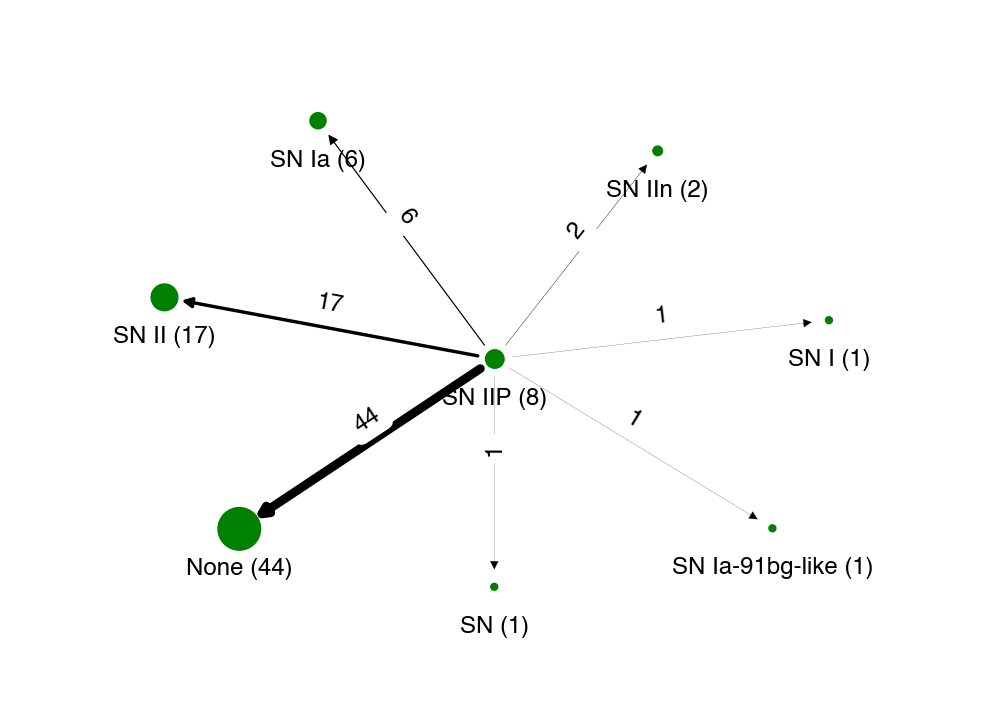

SN IIb


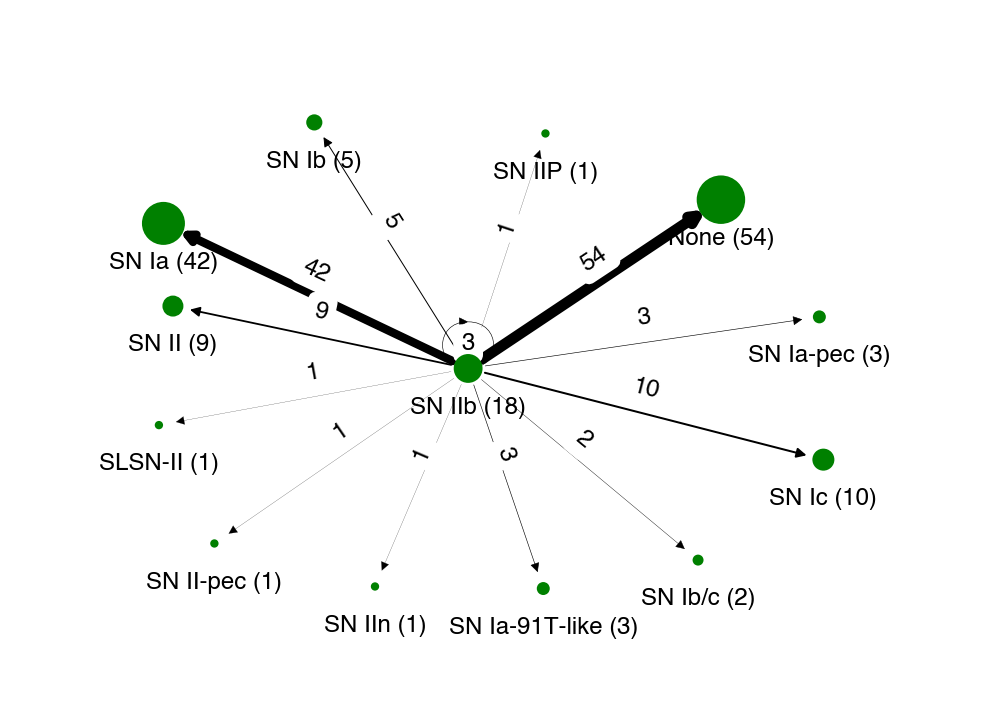

SN IIn


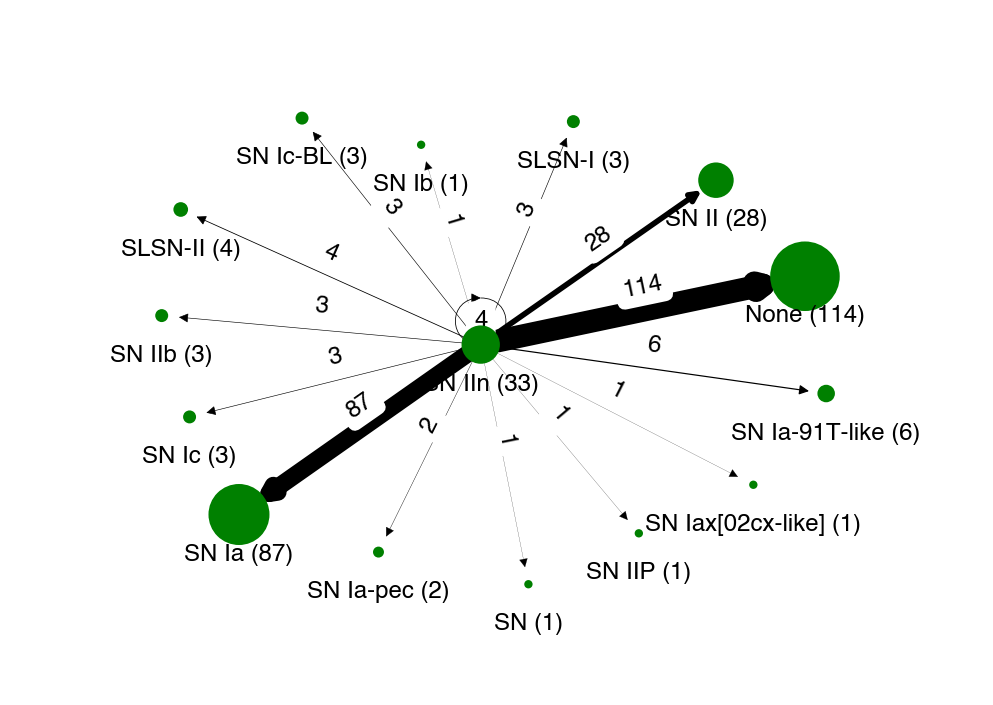

SN Ia


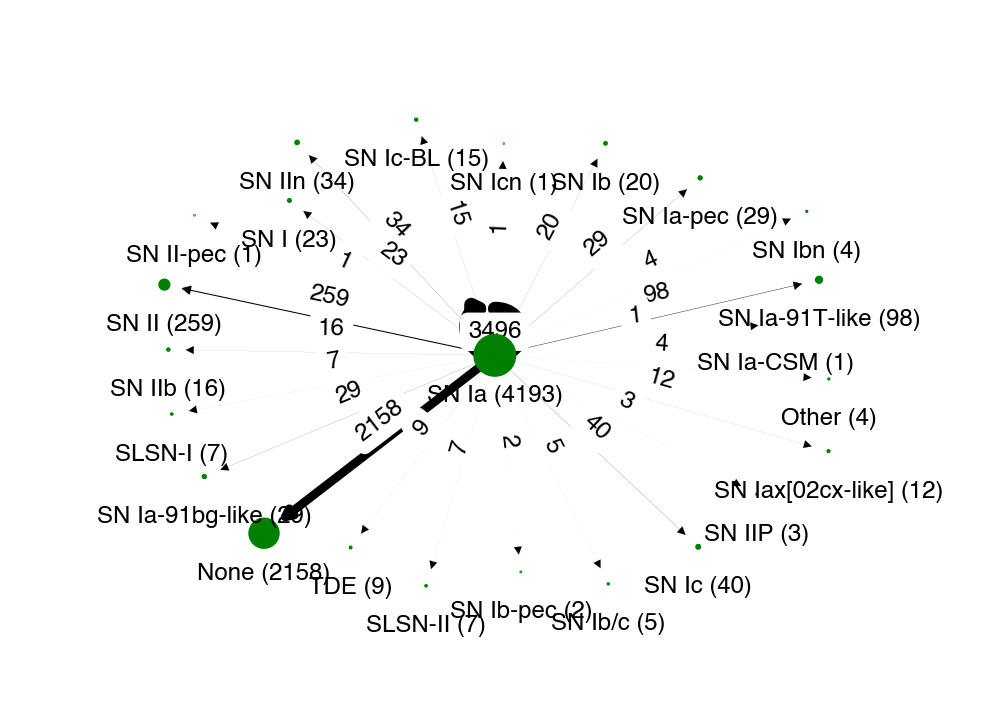

SN Ia-91T-like


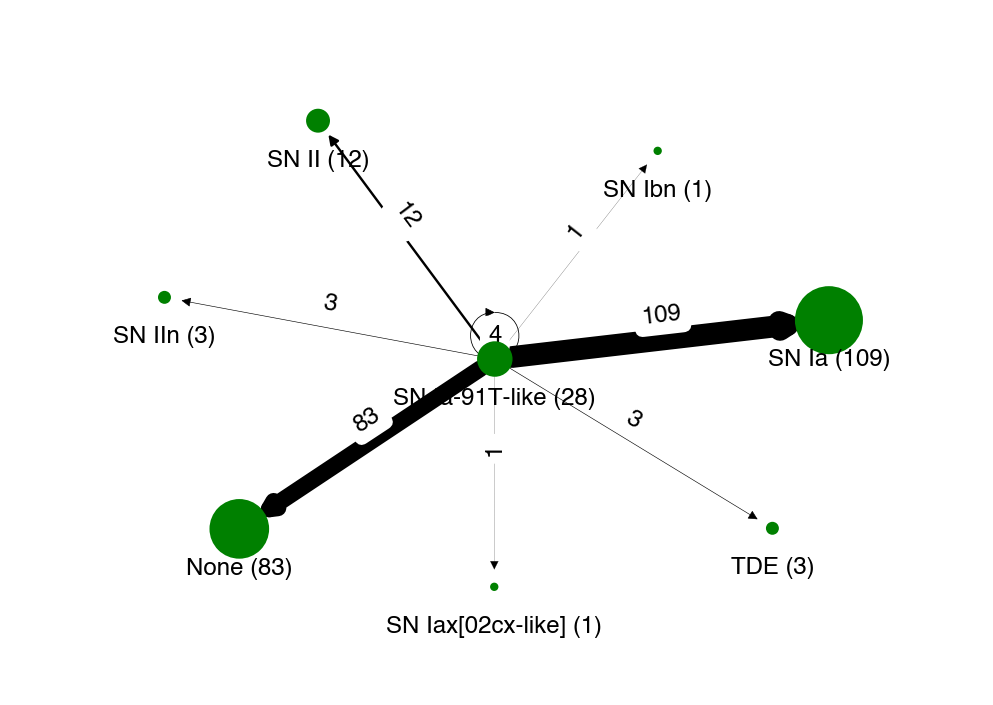

SN Ia-91bg-like


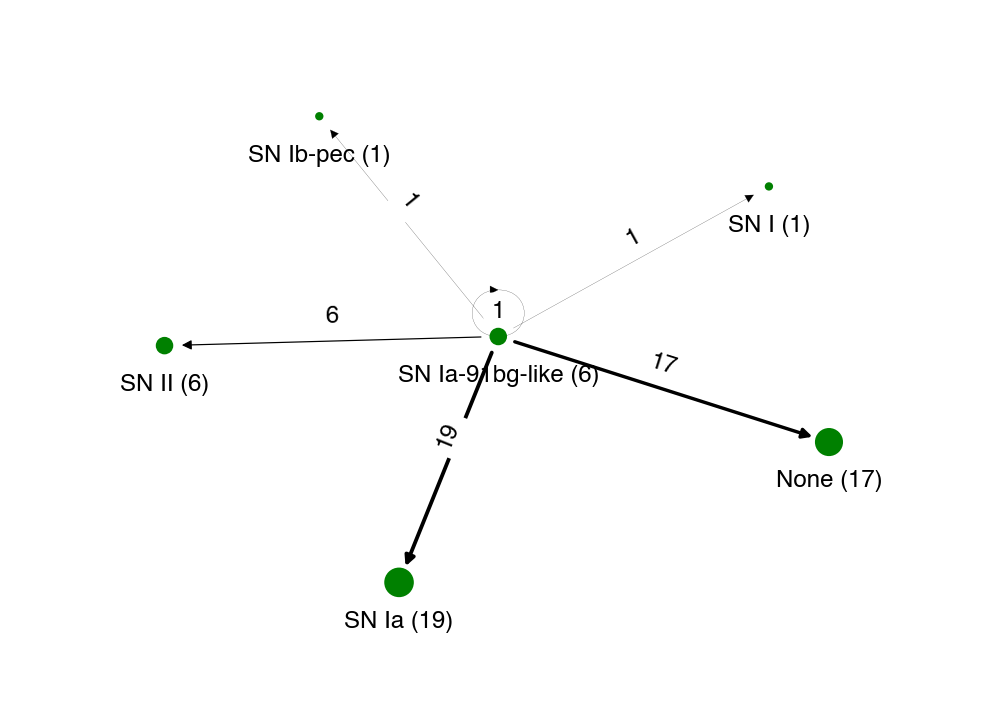

SN Ia-CSM


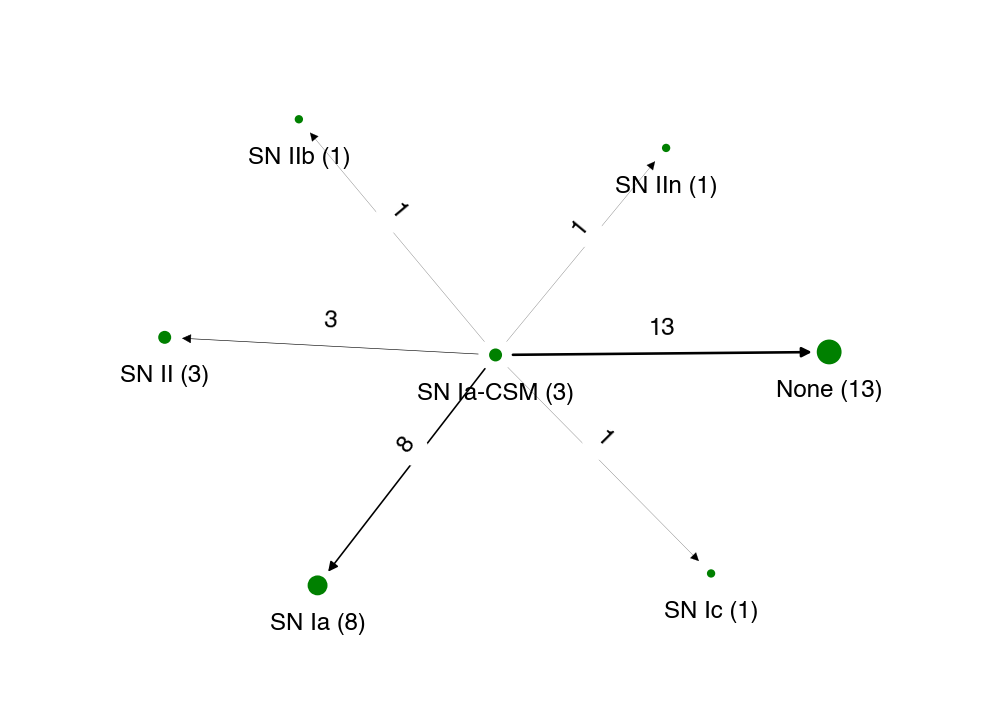

SN Ia-pec


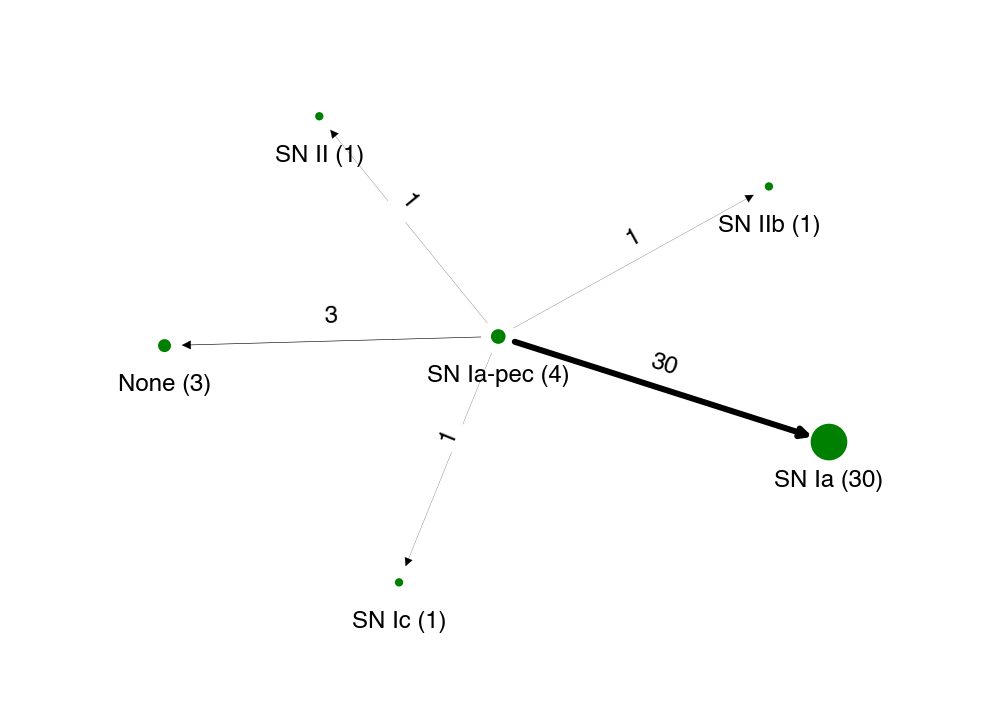

SN Iax[02cx-like]


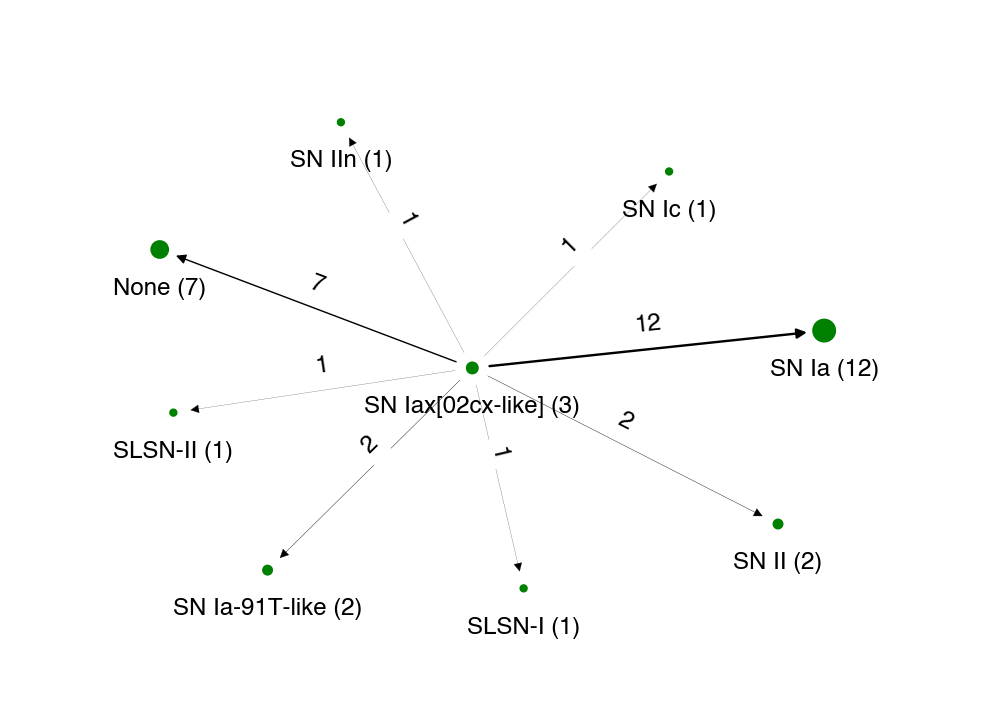

SN Ib


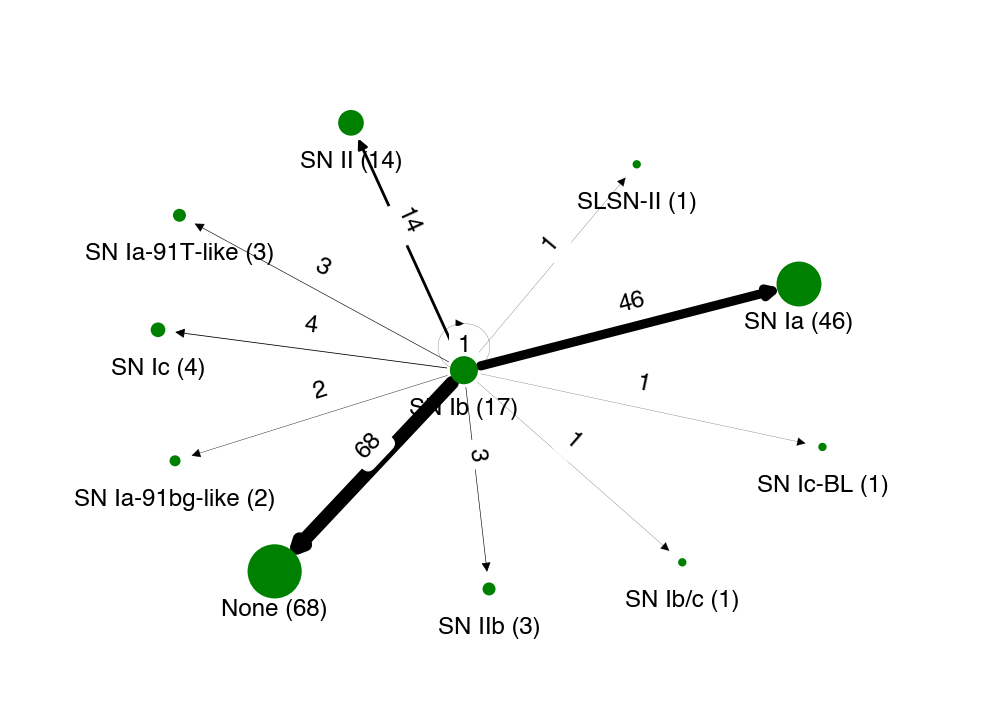

SN Ib-pec


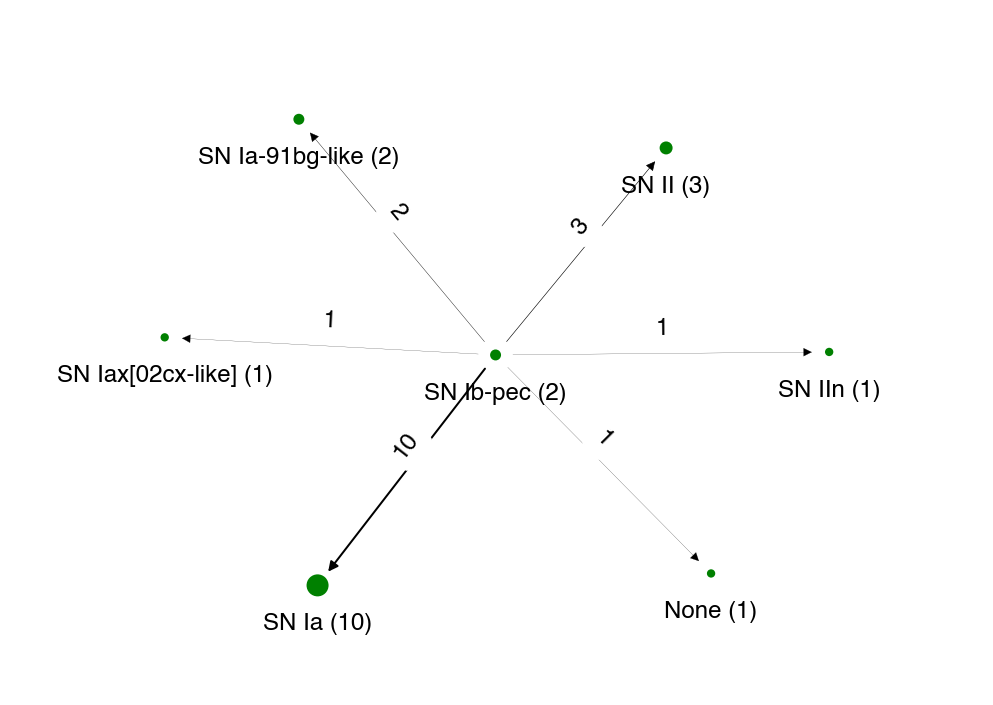

SN Ib/c


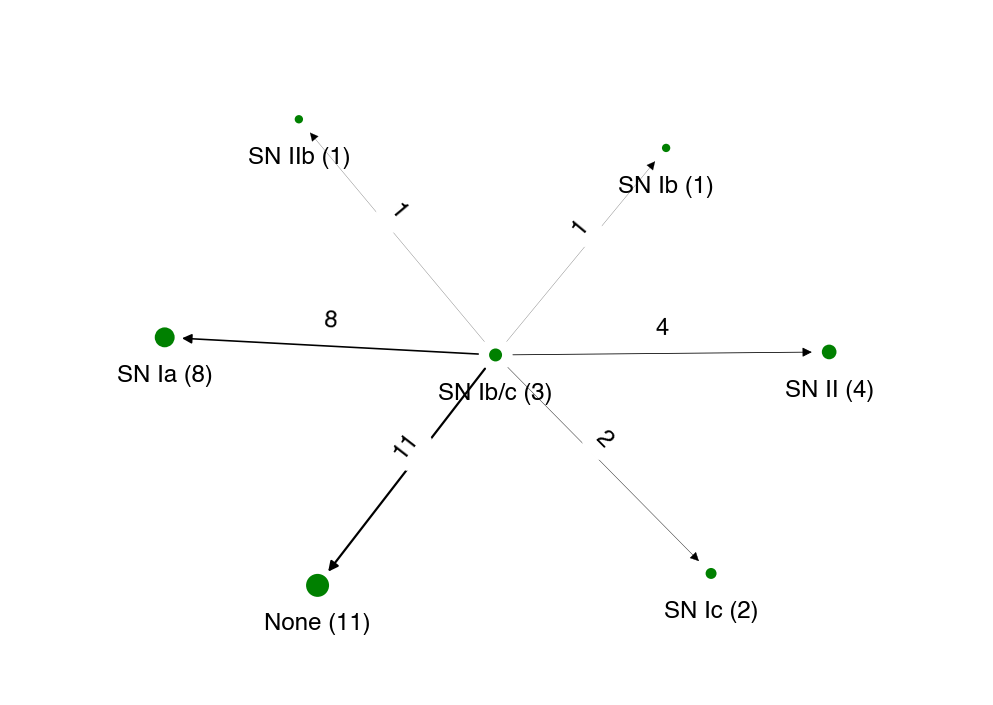

SN Ibn


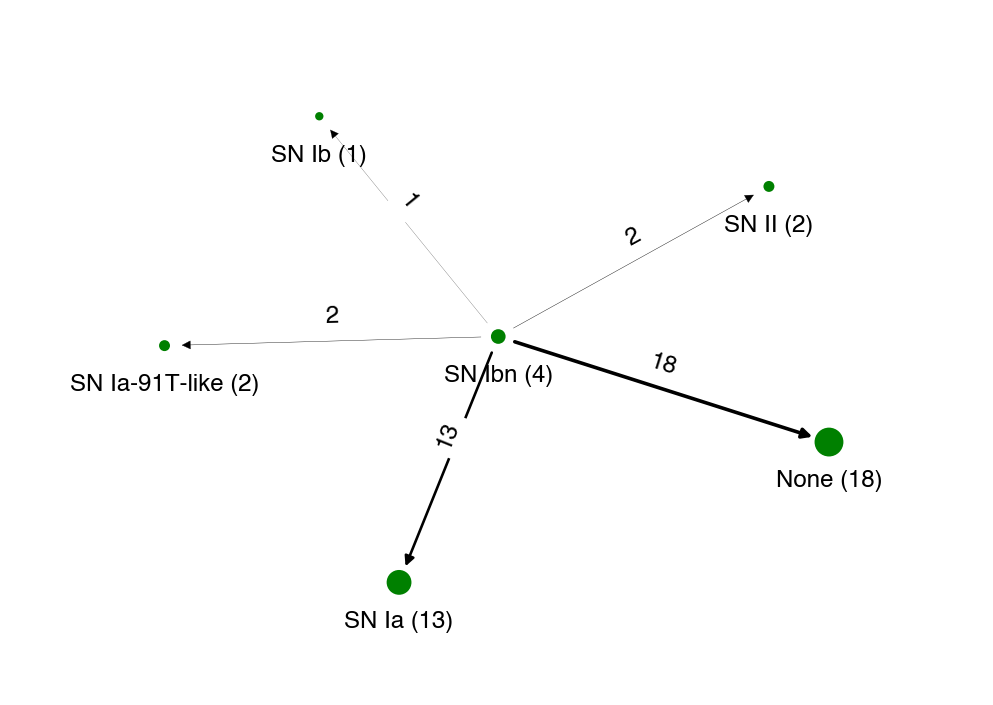

SN Ic


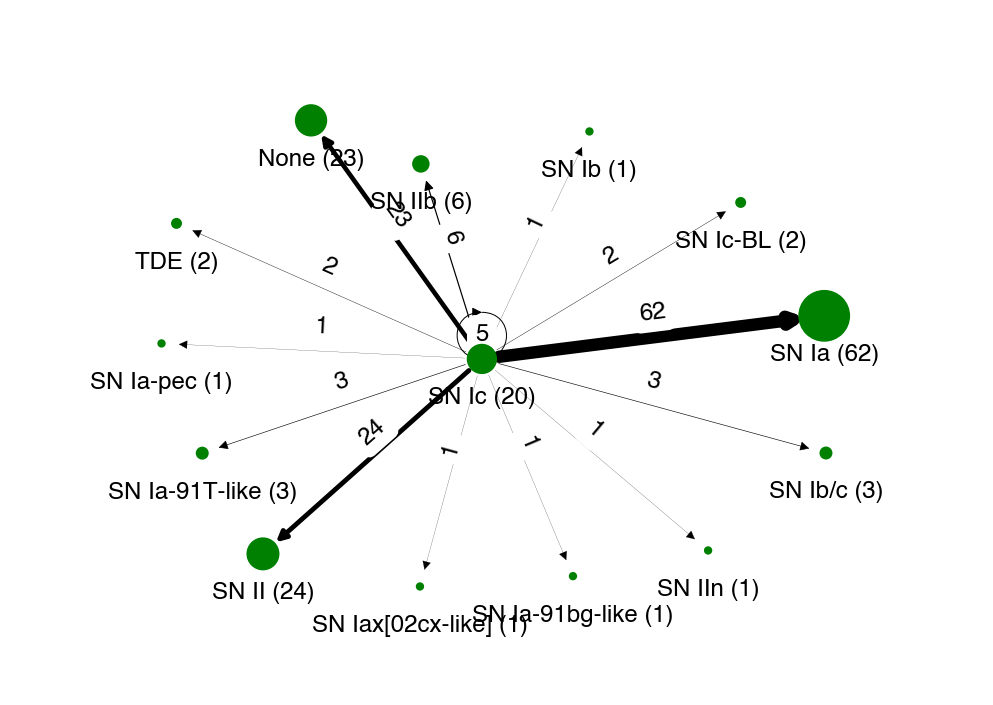

SN Ic-BL


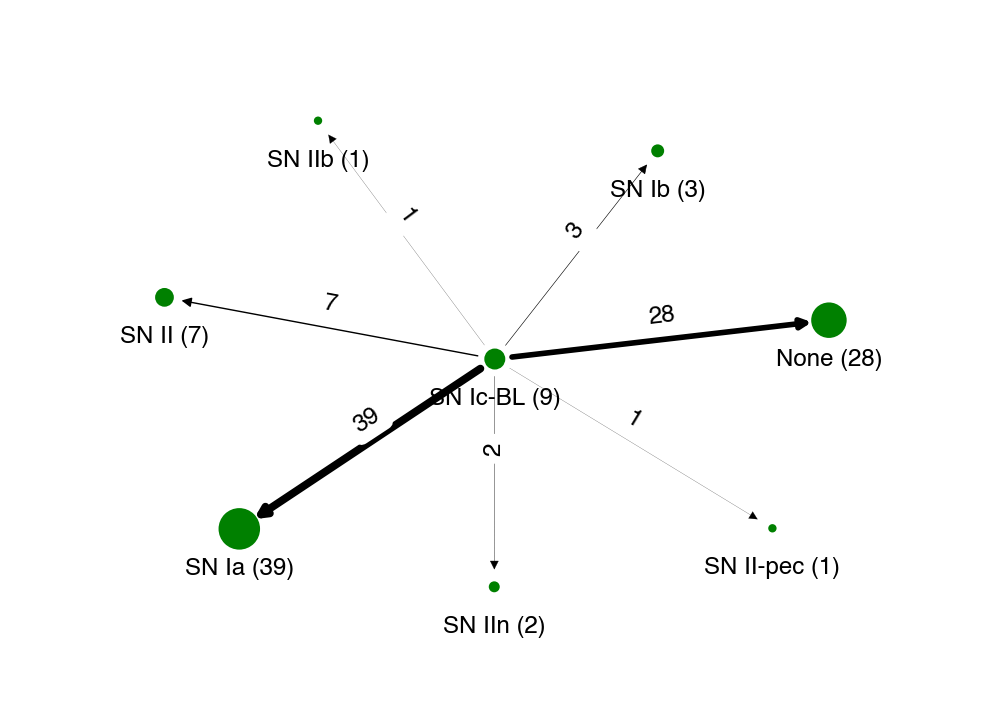

SN Icn


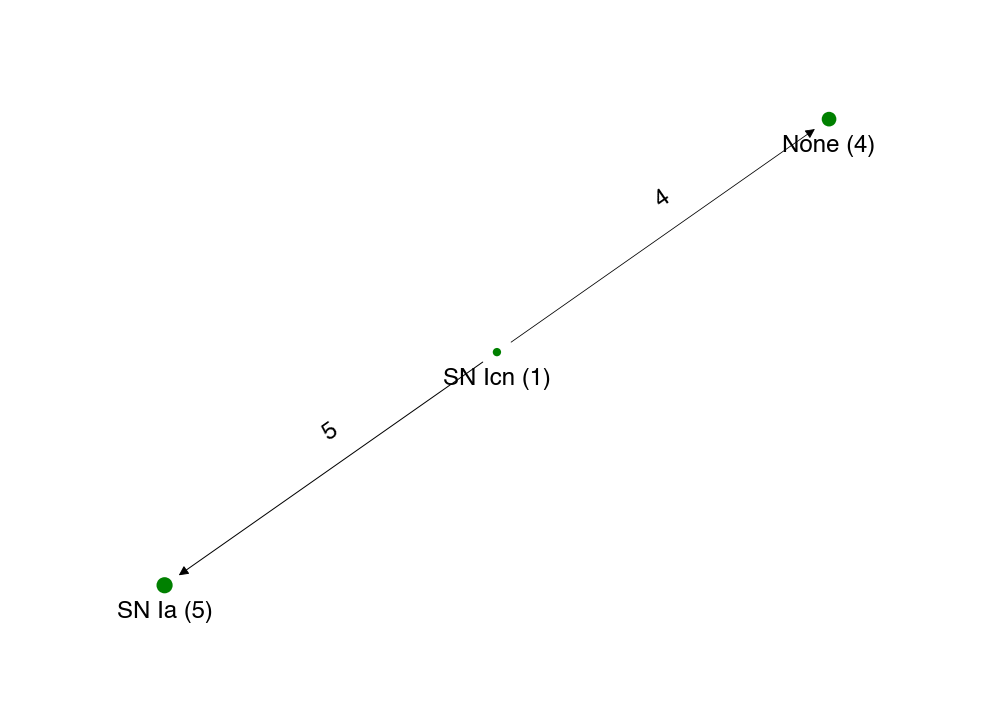

TDE


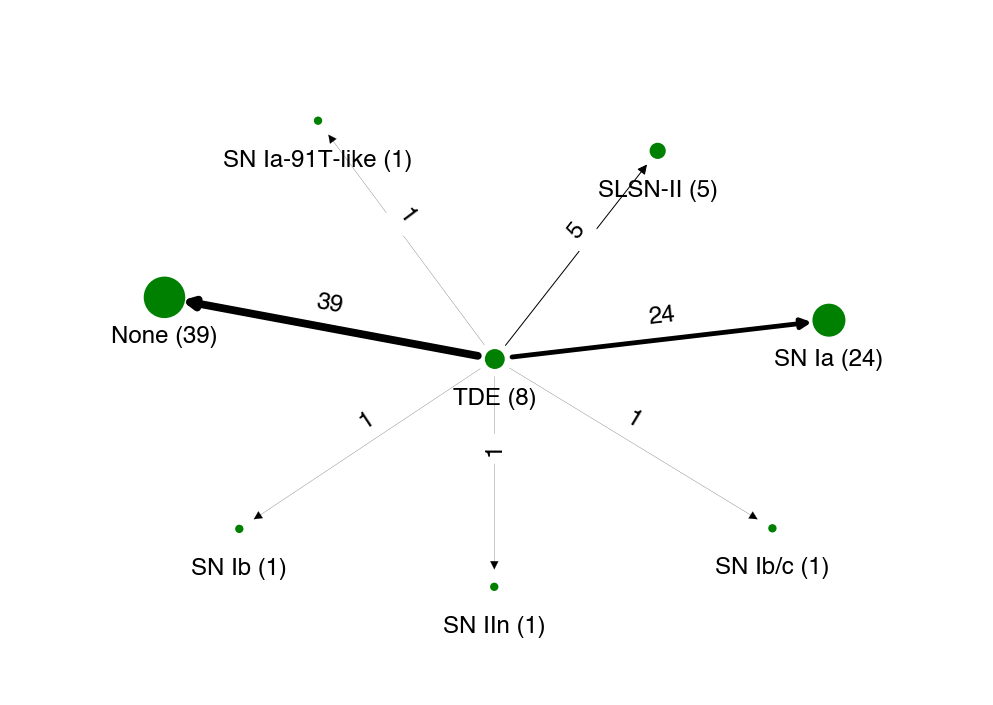

In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/500 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/10 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 10 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
    plt.show()
